#**Imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

#**Data Imports and Preprocessing**

## Austin

### Preprocessing

In [3]:
ai_df = pd.read_csv('./drive/Shareddrives/519/dataset/austin_in.csv')
ao_df = pd.read_csv('./drive/Shareddrives/519/dataset/austin_out.csv')

In [4]:
ai_df['DateTime'] = pd.to_datetime(ai_df['DateTime'])
ao_df['DateTime'] = pd.to_datetime(ao_df['DateTime'])

In [5]:
ai_df = ai_df.sort_values(by='DateTime')
ao_df = ao_df.sort_values(by='DateTime')

In [6]:
ais_df = ai_df.copy()
aos_df = ao_df.copy()

g = ais_df.groupby('Animal ID')
ais_df['Animal ID'] += g.cumcount().add(1).astype(str).radd('_').mask(g['Animal ID'].transform('count')==1,'')
g = aos_df.groupby('Animal ID')
aos_df['Animal ID'] += g.cumcount().add(1).astype(str).radd('_').mask(g['Animal ID'].transform('count')==1,'')

In [7]:
am_df = aos_df.merge(ais_df[['Animal ID', 'DateTime']], on='Animal ID')
am_df = am_df.rename(columns={'DateTime_x': 'DateTime_out', 'DateTime_y': 'DateTime_in'})

In [8]:
def to_cost(row):
  if row['Outcome Type'] == 'Adoption':
    if row['Animal Type'] == 'Cat':
      return 80 if row['Age in days'] < 2557 else 0
    elif row['Animal Type'] == 'Dog':
      if row['Age in days'] < 183:
        return 100
      elif row['Age in days'] < 2557:
        return 80
      else:
        return 0

In [9]:
am_df['Date of Birth'] = pd.to_datetime(am_df['Date of Birth'])
am_df['Age in days'] = (am_df['DateTime_out'] - am_df['Date of Birth']).dt.days
am_df['Cost'] = am_df.apply(to_cost, axis=1)
am_df['Days Stayed'] = (am_df['DateTime_out'] - am_df['DateTime_in']).dt.days

In [10]:
invalid = am_df[(am_df['Outcome Type'] == 'Adoption') & (am_df['Days Stayed'] < 0)]['Animal ID'].tolist()

In [11]:
for i, v in enumerate(invalid):
  if v.find('_') != -1:
    invalid[i] = invalid[i][:-2]

In [12]:
am_df['Outcome Type'].unique()

array(['Transfer', 'Return to Owner', 'Euthanasia', 'Adoption', 'Died',
       'Disposal', 'Missing', nan, 'Relocate', 'Rto-Adopt', 'Lost',
       'Stolen'], dtype=object)

In [13]:
invalid_rows = ao_df[ao_df['Animal ID'].isin(invalid)].sort_values(by='DateTime').groupby('Animal ID').nth(0)
merged = ao_df.merge(invalid_rows, how='left', indicator=True)
merged = merged[merged['_merge'] == 'left_only']

In [14]:
ao_df = merged.drop(columns={'_merge'})

In [15]:
am_df.to_csv('austin_joined.csv')

### Analysis

In [16]:
au_df = pd.read_csv('./drive/Shareddrives/519/dataset/austin_joined.csv')

In [17]:
au_df['Intake Date'] = pd.to_datetime(au_df['Intake Date']).dt.date
au_df['Outcome Date'] = pd.to_datetime(au_df['Outcome Date']).dt.date

In [18]:
au_df.columns

Index(['Animal ID', 'Name', 'Intake Date', 'Outcome Date', 'MonthYear',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex', 'Breed',
       'Color', 'Age in Days', 'Cost', 'Days in Shelter'],
      dtype='object')

In [19]:
au_df[au_df['Outcome Type'] == 'Adoption'].groupby('Outcome Subtype', dropna=False)['Animal ID'].count()

Outcome Subtype
Barn           3
Foster     13229
Offsite      464
NaN        52948
Name: Animal ID, dtype: int64

In [20]:
au_df.to_csv('austin_joined.csv', index=False)

In [21]:
au_df = au_df[au_df['Age in Days'] >= 0]

## Bloomington

In [22]:
bl_df = pd.read_csv('./drive/Shareddrives/519/dataset/bloomington.csv')

In [23]:
bl_df = bl_df[['id', 'intakedate', 'animalname', 'breedname', 'basecolour', \
               'speciesname', 'animalage', 'sexname', 'movementdate', 'movementtype']]
bl_df['id'] = bl_df['id'].apply(str)
bl_df['Outcome Subtype'] = np.nan
bl_df = bl_df.rename({'id': 'Animal ID', 'intakedate': 'Intake Date', 'animalname': 'Name', \
              'breedname': 'Breed', 'basecolour': 'Color', 'speciesname': 'Animal Type', \
              'sexname': 'Sex', 'movementdate': 'Outcome Date', \
              'movementtype': 'Outcome Type'}, axis=1)

In [24]:
bl_df = bl_df.drop_duplicates()
bl_df = bl_df[bl_df['Intake Date'].notnull() & bl_df['Outcome Date'].notnull()]
bl_df['Intake Date'] = pd.to_datetime(bl_df['Intake Date']).dt.date
bl_df['Outcome Date'] = pd.to_datetime(bl_df['Outcome Date']).dt.date
bl_df = bl_df.sort_values(by='Outcome Date')

In [25]:
def to_age_in_days(row):
  words = row['animalage'].split(' ')
  month = 0
  for i, w in enumerate(words):
    if w.startswith('y'):
      words[i] = 'y'
    if w.startswith('m'):
      month = int(words[i-1])
      words[i-1] = '0'
      words[i] = 'm'
    if w.startswith('w'):
      words[i] = 'w'
    if w.startswith('d'):
      words[i] = 'd'
  month_str = '{} d'.format(month * 30)
  try:
    age = pd.to_timedelta(' '.join(words)) + pd.to_timedelta(month_str)
  except:
    return np.nan
  
  td = row['Outcome Date'] - row['Intake Date']
  return td.days + age.days

In [26]:
def to_cost(row):
  if row['Outcome Type'] == 'Adoption' and row['Animal Type'] in ['Cat', 'Dog']:
      return 75 if row['Age in Days'] < 1827 else 55

In [27]:
def to_my(dto):
  my = dto.strftime('%b %Y')
  return my

In [28]:
def to_days_stayed(row):
  if row['Animal Type'] in ['Cat', 'Dog']:
    return (row['Outcome Date'] - row['Intake Date']).days

In [29]:
bl_df['Age in Days'] = bl_df.apply(to_age_in_days, axis=1)
bl_df['Cost'] = bl_df.apply(to_cost, axis=1)
bl_df['MonthYear'] = bl_df['Outcome Date'].apply(to_my)
bl_df['Days in Shelter'] = bl_df.loc[bl_df[bl_df['Outcome Type'] == 'Adoption'].groupby(['Animal ID']).head(1).index].apply(to_days_stayed, axis=1)

/usr/local/lib/python3.8/dist-packages/pandas/core/tools/timedeltas.py:142: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


In [30]:
bl_df = bl_df.drop(columns={'animalage'})
bl_df = bl_df[(bl_df['Days in Shelter'] >= 0) | (bl_df['Days in Shelter'].isnull())]

In [31]:
pd.concat(g for _, g in bl_df[bl_df['Outcome Type'] == 'Adoption'].groupby(['Animal ID']) if len(g) > 1)

,Animal ID,Intake Date,Name,Breed,Color,Animal Type,Sex,Outcome Date,Outcome Type,Outcome Subtype,Age in Days,Cost,MonthYear,Days in Shelter
6,31469,2013-03-26,Bonnie,Basenji/Mix,Brown and White,Dog,Female,2013-03-30,Adoption,NaN,3381.0,55.0,Mar 2013,4.0
7,31469,2013-03-26,Bonnie,Basenji/Mix,Brown and White,Dog,Female,2017-05-09,Adoption,NaN,4882.0,55.0,May 2017,NaN
49,47502,2017-02-27,Zoey,Pitbull/Mix,Grey and White,Dog,Female,2017-04-08,Adoption,NaN,2231.0,55.0,Apr 2017,40.0
50,47502,2017-02-27,Zoey,Pitbull/Mix,Grey and White,Dog,Female,2017-06-01,Adoption,NaN,2285.0,55.0,Jun 2017,NaN
56,47539,2017-03-04,Zack Attack,Domestic Short Hair/Unknown,Grey and White,Cat,Male,2017-04-01,Adoption,NaN,2979.0,55.0,Apr 2017,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24561,74685,2022-09-30,Gina,Mix,Red and White,Dog,Female,2022-10-15,Adoption,NaN,195.0,75.0,Oct 2022,NaN
24661,74760,2022-10-07,Cedar,Domestic Short Hair,Black and Brown,Cat,Female,2022-10-15,Adoption,NaN,738.0,75.0,Oct 2022,8.0
24662,74760,2022-10-07,Cedar,Domestic Short Hair,Black and Brown,Cat,Female,2022-10-27,Adoption,NaN,750.0,75.0,Oct 2022,NaN
24716,74832,2022-10-15,Palio,Husky,Black and White,Dog,Male,2022-10-28,Adoption,NaN,378.0,75.0,Oct 2022,13.0


In [32]:
bl_df = bl_df.drop(bl_df[(bl_df['Animal Type'].isin(['Cat', 'Dog'])) & (bl_df['Days in Shelter'].isnull())].index)

In [33]:
bl_df = bl_df[['Animal ID', 'Name', 'Intake Date', 'Outcome Date', 'MonthYear',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex', 'Breed',
       'Color', 'Age in Days', 'Cost', 'Days in Shelter']]

In [34]:
bl_df.to_csv('bloomington_cleaned.csv', index=False)

## Sonoma

In [35]:
so_df = pd.read_csv('./drive/Shareddrives/519/dataset/sonoma.csv')

In [36]:
so_df = so_df[['Name', 'Type', 'Breed', 'Color', 'Sex', 'Date Of Birth',
       'Animal ID', 'Intake Date', 'Outcome Date', 'Days in Shelter',
       'Outcome Type', 'Outcome Subtype']]

In [37]:
so_df = so_df[so_df['Outcome Date'].notnull()]
so_df = so_df.drop_duplicates()

In [38]:
so_df['Type'].unique()

array(['CAT', 'DOG', 'OTHER'], dtype=object)

In [39]:
so_df['Intake Date'] = pd.to_datetime(so_df['Intake Date']).dt.date
so_df['Outcome Date'] = pd.to_datetime(so_df['Outcome Date']).dt.date
so_df['Date Of Birth'] = pd.to_datetime(so_df['Date Of Birth']).dt.date
so_df = so_df.sort_values(by='Outcome Date')

In [40]:
def to_cost(row):
  if row['Outcome Type'] == 'ADOPTION':
    if row['Type'] == 'CAT':
      if row['Age in Days'] < 123:
        return 126.20
      elif row['Age in Days'] < 2192:
        return 90.30
      else:
        return 60.58
    elif row['Type'] == 'DOG':
      if row['Age in Days'] < 123:
        return 192.03
      elif row['Age in Days'] < 2192:
        return 144.03
      else:
        return 107.45
        

In [41]:
def to_my(dto):
  my = dto.strftime('%b %Y')
  return my

In [42]:
so_df['Age in Days'] = (so_df['Outcome Date'] - so_df['Date Of Birth']).dt.days
so_df['Cost'] = so_df.apply(to_cost, axis=1)
so_df['MonthYear'] = so_df['Outcome Date'].apply(to_my)

In [43]:
so_df = so_df[(so_df['Age in Days'] > 0) | so_df['Age in Days'].isnull()]

In [44]:
so_df = so_df.rename({'Type': 'Animal Type'}, axis=1)

In [45]:
so_df = so_df[['Animal ID', 'Name', 'Intake Date', 'Outcome Date', 'MonthYear',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex', 'Breed',
       'Color', 'Age in Days', 'Cost', 'Days in Shelter']]

In [46]:
so_df.to_csv('sonoma_cleaned.csv', index=False)

In [47]:
master_df = pd.concat([au_df, bl_df, so_df])

In [48]:
master_df.head()

,Animal ID,Name,Intake Date,Outcome Date,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex,Breed,Color,Age in Days,Cost,Days in Shelter
0,A664235,NaN,2013-10-01,2013-10-01,Oct 2013,Transfer,Partner,Cat,Unknown,Domestic Shorthair Mix,Orange/White,7.0,NaN,0.0
1,A664237,NaN,2013-10-01,2013-10-01,Oct 2013,Transfer,Partner,Cat,Unknown,Domestic Shorthair Mix,Orange/White,7.0,NaN,0.0
2,A664236,NaN,2013-10-01,2013-10-01,Oct 2013,Transfer,Partner,Cat,Unknown,Domestic Shorthair Mix,Orange/White,7.0,NaN,0.0
3,A664258,Sylvio,2013-10-01,2013-10-01,Oct 2013,Return to Owner,NaN,Dog,Neutered Male,Weimaraner Mix,Silver,2557.0,NaN,0.0
4,A648744,Claire,2013-10-01,2013-10-01,Oct 2013,Return to Owner,NaN,Dog,Spayed Female,Anatol Shepherd Mix,White/Tricolor,576.0,NaN,0.0


In [49]:
master_df.to_csv('master.csv', index=False)

## Master

In [50]:
master = pd.read_csv('./drive/Shareddrives/519/dataset/master.csv')

In [51]:
master.columns

Index(['animal_id', 'name', 'intake_date', 'outcome_date', 'monthyear',
       'outcome_type', 'outcome_subtype', 'animal_type', 'sex', 'breed',
       'color', 'age_in_days', 'cost', 'days_in_shelter'],
      dtype='object')

In [52]:
master = master.drop(columns=['monthyear'])

In [53]:
master['intake_date'] = pd.to_datetime(master['intake_date'])
master['outcome_date'] = pd.to_datetime(master['outcome_date'])

In [54]:
master.astype(str).replace('nan',np.nan).describe()

,animal_id,name,intake_date,outcome_date,outcome_type,outcome_subtype,animal_type,sex,breed,color,age_in_days,cost,days_in_shelter
count,190650,142102,190650,190650,190620,89731,190650,190647,190586,190650,184696,84441,179259
unique,180910,36009,3334,3321,23,259,31,9,4686,1009,5925,11,649
top,A322298,Luna,2017-09-01,2019-08-17,Adoption,Partner,Dog,Neutered Male,Domestic Shorthair Mix,Black,366.0,80.0,0.0
freq,19,710,187,290,79529,34614,88743,50691,32719,15156,2544,51103,23988


In [55]:
master.animal_type.unique()

array(['Cat', 'Dog', 'Other', 'Bird', 'Livestock', 'House Rabbit', 'Rat',
       'Opossum', 'Wildlife - other', 'Ferret', 'Chicken', 'Tortoise',
       'Pig', 'Guinea Pig', 'Hamster', 'Gerbil', 'Lizard', 'Hedgehog',
       'Chinchilla', 'Goat', 'Snake', 'Squirrel', 'Sugar Glider',
       'Turtle', 'Tarantula', 'Mouse', 'Raccoon', 'Fish', 'DOG', 'CAT',
       'OTHER'], dtype=object)

#**Data Cleaning and E.D.A**

### Categorical Data Analysis & Preprocessing

We will take a closer look into columns that are crucial inputs of our model training, to see if further cleaning and analysis might be needed, starting with categorical columns.

In [56]:
# Take a copy of the dataframe first
master_cleaned_df = master

In [57]:
# Find out categorical columns
master_cleaned_df.select_dtypes(exclude=[np.number]).columns

Index(['animal_id', 'name', 'intake_date', 'outcome_date', 'outcome_type',
       'outcome_subtype', 'animal_type', 'sex', 'breed', 'color'],
      dtype='object')

In [58]:
master_cleaned_df['outcome_type'].unique()

array(['Transfer', 'Return to Owner', 'Euthanasia', 'Died', 'Adoption',
       'Disposal', 'Missing', nan, 'Relocate', 'Rto-Adopt', 'Lost',
       'Stolen', 'Foster', 'Reclaimed', 'Released To Wild', 'Escaped',
       'EUTHANIZE', 'ADOPTION', 'RETURN TO OWNER', 'TRANSFER', 'DIED',
       'ESCAPED/STOLEN', 'DISPOSAL', 'RTOS'], dtype=object)

We noticed that there are values which seems to be the same but of a slightly different name, such as `ADOPTION` and `Adoption`. Similar issue applies to other columns as well. We will make all field values lowercase to resolve this.

In [59]:
string_fields = ['outcome_type', 'outcome_subtype', 'animal_type', 'breed', 'sex', 'color']
for string_field in string_fields:
  master_cleaned_df[string_field] = master_cleaned_df[string_field].str.lower()

# Validate on one of the columns
master_cleaned_df['outcome_type'].unique()

array(['transfer', 'return to owner', 'euthanasia', 'died', 'adoption',
       'disposal', 'missing', nan, 'relocate', 'rto-adopt', 'lost',
       'stolen', 'foster', 'reclaimed', 'released to wild', 'escaped',
       'euthanize', 'escaped/stolen', 'rtos'], dtype=object)

#### Animal Gender & Spay/Neuter Data

The gender of animal is sometimes taken into consider during adoption, and could potentially be an important features. Taking a closer look into the data in the `sex` column, we see that it contains information on both the animal's gender and whether neutered/spayed or not (**neuter indicates male and spay indicates female**). We will update the `sex` column to include only animal's gender (`male`, `female`, or null or `unknown`), and add another column for neutered/spayed information. 

In [60]:
master_cleaned_df['sex'].unique()

array(['unknown', 'neutered male', 'spayed female', 'intact female',
       'intact male', nan, 'female', 'male', 'spayed', 'neutered'],
      dtype=object)

In [61]:
# Get the percentage of each diff gender
master_cleaned_df['sex'].value_counts(normalize=True)

neutered male    0.265889
spayed female    0.239831
intact male      0.097547
intact female    0.095071
male             0.077536
female           0.075160
unknown          0.072695
neutered         0.041774
spayed           0.034498
Name: sex, dtype: float64

We notice that unknown only takes up 7%, we think it is reasonable to keep this feature with unknown values being NULL for model training. 

In [62]:
def update_sex_info(gender_str):
  if gender_str in ['spayed female', 'intact female', 'female', 'spay']:
    return 1
  elif gender_str in ['neutered male', 'intact male', 'male', 'neutered']:
    return 0
  else:
    return None

def get_spay_or_neuter_info(gender_str):
  if gender_str in ['spayed female', 'spay', 'neutered male', 'neutered']:
    return 1
  elif gender_str in ['intact male', 'intact female']:
    return 0
  else:
    return None

In [63]:
master_cleaned_df['if_neutered_or_spayed'] = master_cleaned_df['sex'].apply(get_spay_or_neuter_info)
master_cleaned_df['gender'] = master_cleaned_df['sex'].apply(update_sex_info)
master_cleaned_df = master_cleaned_df.drop(columns=['sex'])
print("Possible gender values are: ", master_cleaned_df['gender'].unique())
print("Neuter/Spay info: ", master_cleaned_df['if_neutered_or_spayed'].unique())

Possible gender values are:  [nan  0.  1.]
Neuter/Spay info:  [nan  1.  0.]


In [64]:
gender_neuter_analysis_df = master_cleaned_df.groupby(['gender','if_neutered_or_spayed'])['animal_id'].count().reset_index()
gender_neuter_analysis_df = gender_neuter_analysis_df.rename(columns={'animal_id' : 'count'})

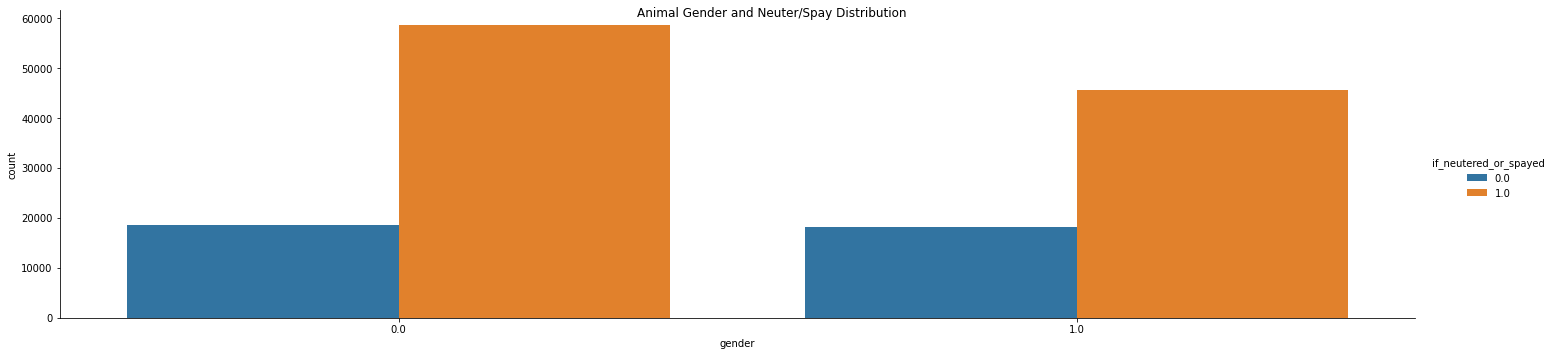

In [65]:
g = sns.catplot(x = 'gender', y='count', 
               hue = 'if_neutered_or_spayed',data=gender_neuter_analysis_df, height=5, aspect=4, kind='bar')
g.fig.suptitle("Animal Gender and Neuter/Spay Distribution")
g.fig.show()

#### Animal Outcome Data

In [66]:
# outcome_type possible values
master_cleaned_df['outcome_type'].unique()

array(['transfer', 'return to owner', 'euthanasia', 'died', 'adoption',
       'disposal', 'missing', nan, 'relocate', 'rto-adopt', 'lost',
       'stolen', 'foster', 'reclaimed', 'released to wild', 'escaped',
       'euthanize', 'escaped/stolen', 'rtos'], dtype=object)

We will merge some of the values that indicate the same type of outcome, such as `euthanize` and `euthanasia` etc, and `escaped`, `lost`, `stolen`, `missing`, `escaped/stolen` into one value named `escaped/stolen/lost`

In [67]:
def merge_certain_outcome_type(outcome):
  if outcome == 'euthanize':
    return 'euthanasia'
  elif outcome in ['lost', 'escaped', 'missing', 'stolen', 'escaped/stolen']:
    return 'escaped/stolen/lost'
  elif outcome in ['rto-adopt', 'rtos', 'return to owner', 'reclaimed']:
    return 'return to owner'
  else:
    return outcome

In [68]:
master_cleaned_df['outcome_type'] = master_cleaned_df['outcome_type'].apply(merge_certain_outcome_type)
print(master_cleaned_df['outcome_type'].unique())

['transfer' 'return to owner' 'euthanasia' 'died' 'adoption' 'disposal'
 'escaped/stolen/lost' nan 'relocate' 'foster' 'released to wild']


In [69]:
outcome_types_summary = master_cleaned_df['outcome_type'].value_counts(normalize=True)*100

Let's look into the distribution of different outcome types.

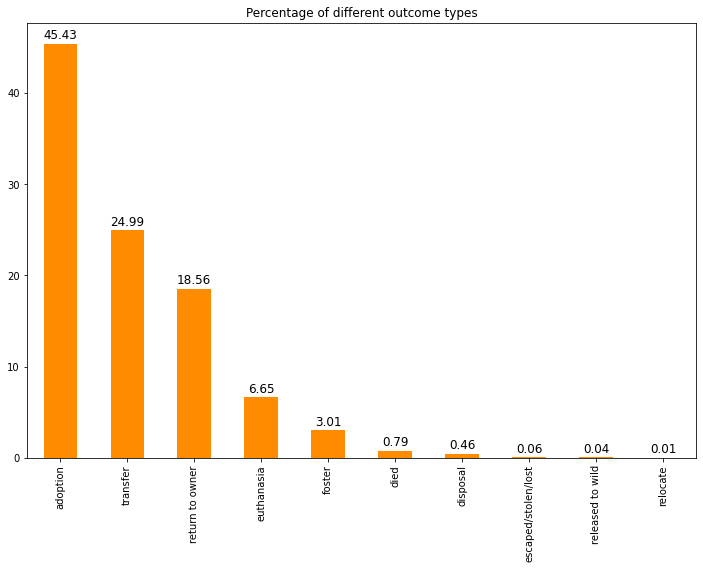

In [70]:
plt.figure(figsize=(12, 8))
plt.title("Percentage of different outcome types")
g = outcome_types_summary.plot.bar(color={"DarkOrange"})
for bar in g.patches:
  g.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
  # ax.annorate
plt.show()

As we are interested in predicting the length of stay before animal being adopted, it is reasonable to exclude most outcome types other than adoption, such as `escaped/stolen/lost`, `relocate`, `released to wild`, `transfer`, `died`, `foster` (taking animals home only temporarily), and `return to owner` (**as owner will only consider adopting their previous animal, which introduces noises to our prediction**). What about `euthanisia`? Should euthanized animal be considered as having infinitely long length of stay as they were probably suitable for adoption, or would including euthanized animals actually introducing more noise to our training? Let's take a closer look into the `outcome_subtype` field to get more information. 

In [71]:
euthanasia_analysis_df = master_cleaned_df[master_cleaned_df['outcome_type'].isin(['euthanasia'])]

In [72]:
euthanasia_analysis_df = euthanasia_analysis_df.groupby(['outcome_type','outcome_subtype'])['animal_id'].count().reset_index()
euthanasia_analysis_df = euthanasia_analysis_df.rename(columns={'animal_id' : 'count'})
euthanasia_analysis_df = euthanasia_analysis_df.sort_values('count', ascending=False).reset_index(drop=True)

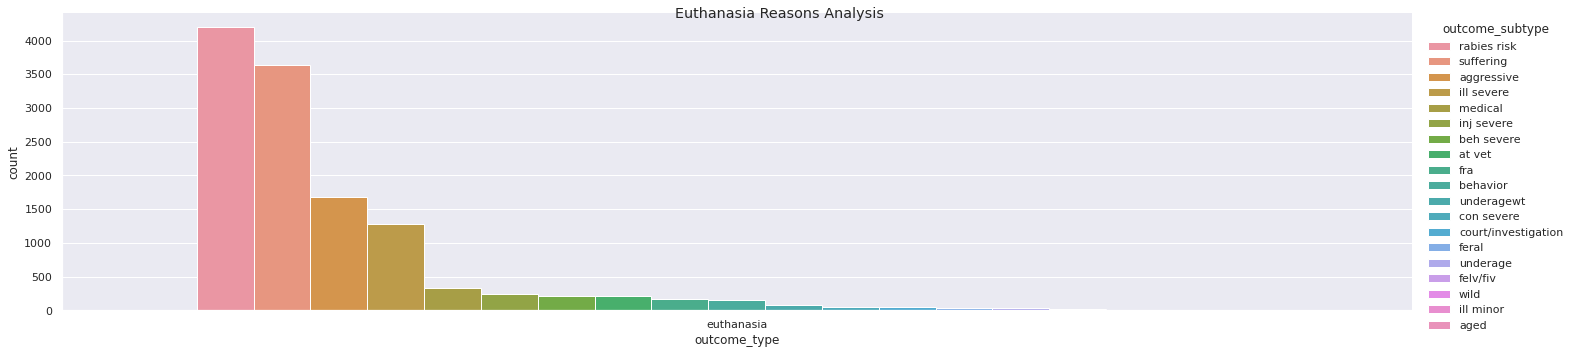

In [73]:
sns.set(rc={'figure.figsize':(12,9)})
g = sns.catplot(x = 'outcome_type', y='count', 
               hue = 'outcome_subtype',data=euthanasia_analysis_df, height=5, aspect=4, kind='bar')
g.fig.suptitle("Euthanasia Reasons Analysis")
g.fig.show()

The above diagram shows that most animals being euthanized are due to real concerns such as rabis risk (the top one reason for euthanasia), suffering, aggresive, or other illness. **Including euthanized animals in our training dataset would introduce more noises, as those animals were not suitable adoption. Hence, we decide to include data for animals with `outcome_type = adoption` only.**

In [74]:
adoption_df = master_cleaned_df[master_cleaned_df['outcome_type'] == 'adoption']

#### Animal Type

What are the different types of animals in the shelter? 

In [75]:
animal_types_data = adoption_df['animal_type'].value_counts(normalize=True)
animal_types_data

dog                 0.535113
cat                 0.440036
other               0.013408
bird                0.003476
house rabbit        0.003026
guinea pig          0.002206
rat                 0.001236
livestock           0.000497
gerbil              0.000185
snake               0.000115
lizard              0.000115
hedgehog            0.000104
fish                0.000069
hamster             0.000069
pig                 0.000058
mouse               0.000058
chinchilla          0.000046
ferret              0.000035
sugar glider        0.000035
chicken             0.000035
wildlife - other    0.000023
turtle              0.000023
tortoise            0.000012
tarantula           0.000012
goat                0.000012
Name: animal_type, dtype: float64

<ipython-input-76-554393cac9cb>:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels=['%s, %1.1f%%' % (l, (float(s) / 1) * 100) for l, s in zip(labels, sizes)], loc="best")


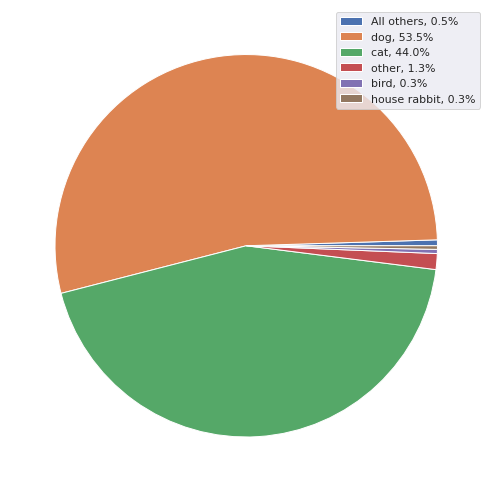

In [76]:
animal_types_aggregated_data={}
animal_types_aggregated_data['All others'] = 0
threshold = 0.003
explode = [0,0,0,0,.1,.1]

for index, value in animal_types_data.iteritems():
  if value < threshold:
    animal_types_aggregated_data['All others'] += value
  else:
    animal_types_aggregated_data[index] = value

plt.figure(figsize=(7, 7))
sizes = animal_types_aggregated_data.values()
labels = animal_types_aggregated_data.keys()
patches, texts = plt.pie(sizes, startangle=0)
plt.legend(patches, labels=['%s, %1.1f%%' % (l, (float(s) / 1) * 100) for l, s in zip(labels, sizes)], loc="best")
plt.tight_layout()
plt.show()

We see that other animals compose a very small percentage of all shelter animals. As we are mostly interested in predicting length of stay for dogs and animals (which are the most common animal types in most shelters), **we will filter out other animal types and focus on dogs and cats only**. 

In [77]:
adoption_df = adoption_df[adoption_df['animal_type'].isin(['dog', 'cat'])]

#### Animal Color

In [78]:
def process_color_str(color_str):
  color_str = color_str.replace(' and ', '/')
  color_str = color_str.replace(', ', '/')
  color_str = color_str.replace('blk ', 'black ')
  color_str = color_str.replace('bl ', 'blue ')
  color_str = color_str.replace('brn ', 'brown ')
  color_str = color_str.replace('br ', 'brown ')
  color_str = color_str.replace('y brindle', 'yellow brindle')
  color_str = color_str.replace('slvr ', 'silver ')
  color_str = color_str.replace('siver ', 'silver ')
  color_str = color_str.replace('pt', 'point')
  color_str = color_str.replace('tricolour', 'tricolor')
  color_str = color_str.replace('chocolate', 'choc')
  color_str = color_str.replace('with', '')
  color_str = color_str.replace(' ', '/')
  color_str = color_str.replace('golden', 'gold')
  color_str = color_str.replace('gray', 'grey')
  color_str = color_str.replace('org', 'orange')
  color_str = color_str.replace('tortie', 'torti')
  color_str = color_str.replace('tricolor', '')
  color_str = color_str.replace('various', '')
  return color_str

adoption_df['color'] = adoption_df['color'].apply(process_color_str)

In [79]:
animal_color_data = adoption_df[['color']].value_counts(normalize=True)
animal_color_data

color             
black/white           0.112434
black                 0.088926
brown/tabby           0.053907
brown/white           0.030720
brown/tabby/white     0.029547
                        ...   
black/blue/brindle    0.000012
lilac/point/black     0.000012
liver                 0.000012
liver/tick/brown      0.000012
black/smoke/black     0.000012
Length: 494, dtype: float64

In [80]:
adoption_df['color'].unique()


array(['tan', 'black/tan', 'white', 'white/', 'brown/white', 'white/tan',
       'white/brown/brindle', 'white/brown', 'choc', 'yellow',
       'tan/white', 'calico', 'brown/black', 'blue/white', 'white/black',
       'black', 'brown/tabby', 'orange/tabby', 'torbie', 'black/white',
       'buff', 'seal/point', 'brown/tabby/white', 'tan/cream', 'brown',
       '', 'red/merle', 'torti', 'red/white', 'grey/tan', 'cream', 'red',
       'blue/merle/tan', 'blue/merle/cream', 'black/brown', 'tan/black',
       'apricot', 'fawn', 'buff/white', 'blue/tabby/white', 'blue/merle',
       'blue', 'blue/merle/black', 'brown/merle/white',
       'orange/tabby/white', 'cream/tabby/white', 'choc/white', 'grey',
       'white/red/merle', 'brown/brindle/white', 'cream/tabby',
       'black/grey', 'brown/tiger', 'black/smoke', 'gold/white',
       'white/orange', 'black/red', 'white/red', 'blue/merle/brown',
       'fawn/white', 'grey/black', 'sable/tan', 'black/black/brindle',
       'lynx/point', 'black

In [81]:
dummies = adoption_df['color'].str.get_dummies('/').sum()
print(dummies.sort_values(ascending = False).tail(15))

dilute      245
silver      221
smoke       207
gold        176
tabbico     140
lilac       106
tiger        77
apricot      58
liver        42
agouti       20
siver        16
ruddy         3
cinnamon      3
unknown       2
pink          2
dtype: int64


In [82]:
def process_color_str_after(color_str):
  color_str = color_str.replace('pink', 'other_color')
  color_str = color_str.replace('unknown', 'other_color')
  color_str = color_str.replace('cinnamon', 'other_color')
  color_str = color_str.replace('ruddy', 'other_color')
  color_str = color_str.replace('siver', 'other_color')
  color_str = color_str.replace('agouti', 'other_color')
  return color_str


adoption_df['color'] = adoption_df['color'].apply(process_color_str_after)

In [83]:
dummies = adoption_df['color'].str.get_dummies('/').sum()
print(dummies.sort_values(ascending = False).tail(15))

yellow           551
tortoiseshell    534
seal             405
tick             388
flame            249
dilute           245
silver           221
smoke            207
gold             176
tabbico          140
lilac            106
tiger             77
apricot           58
other_color       46
liver             42
dtype: int64


In [84]:
adoption_df = pd.concat([adoption_df, adoption_df['color'].str.get_dummies(sep='/')], axis=1)

#### Breed Data 

In [85]:
adoption_df = adoption_df[(adoption_df['breed'].notnull()) & (~adoption_df['breed'].isin(['unknown', 'mix']))]

##### Cat

In [86]:
cat_df = adoption_df[(adoption_df['animal_type'] == 'cat') & (adoption_df['breed'].notnull()) & (adoption_df['breed'] != 'unknown')]

In [87]:
sorted(cat_df['breed'].unique())

['abyssinian',
 'abyssinian mix',
 'abyssinian/domestic short hair',
 'abyssinian/mix',
 'american curl',
 'american curl shorthair',
 'american curl shorthair mix',
 'american curl shorthair/siamese',
 'american curl/dsh',
 'american shorthair',
 'american shorthair mix',
 'american wirehair mix',
 'angora mix',
 'balinese',
 'balinese mix',
 'balinese/domestic medium hair',
 'balinese/javanese',
 'balinese/manx',
 'bengal',
 'bengal mix',
 'bengal/domestic sh',
 'bengal/domestic short hair',
 'bengal/domestic shorthair',
 'bobtail',
 'bombay',
 'bombay mix',
 'bombay/domestic short hair',
 'british sh',
 'british shorthair',
 'british shorthair mix',
 'british shorthair/domestic short hair',
 'british shorthair/mix',
 'british shorthair/unknown',
 'burmese',
 'burmese mix',
 'burmese/mix',
 'calico',
 'calico/domestic medium hair',
 'chartreux mix',
 'cornish rex mix',
 'cymric mix',
 'devon rex',
 'devon rex mix',
 'dlh/unknown',
 'dmh/dlh',
 'dmh/dsh',
 'domestic lh',
 'domestic lh

In [88]:
import re
cat_df['breed'] = cat_df['breed'].apply(lambda x: re.sub(r' sh$', ' shorthair', x.replace(' mix', '').replace('/mix', '')
  .replace('/unknown', '').replace('sh/', 'shorthair/').replace('dsh', 'domestic shorthair')
  .replace('domestic short hair', 'domestic shorthair').replace('dlh', 'domestic long hair')
  .replace('domestic lh', 'domestic long hair').replace('domestic longhair', 'domestic long hair')
  .replace('dmh', 'domestic medium hair').replace('domestic mh', 'domestic medium hair'))
  .replace('curl shorthair', 'curl').replace('munchkin longhair', 'munchkin')
  .replace('munchkin shorthair', 'munchkin').replace('pixie-bob', 'pixiebob')
  .replace('pixiebob shorthair', 'pixiebob'))
cat_df['breed'] = cat_df['breed'].replace({'angora': 'turkish angora'})

<ipython-input-88-efb7a8527aa0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['breed'] = cat_df['breed'].apply(lambda x: re.sub(r' sh$', ' shorthair', x.replace(' mix', '').replace('/mix', '')
<ipython-input-88-efb7a8527aa0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['breed'] = cat_df['breed'].replace({'angora': 'turkish angora'})


In [89]:
sorted(cat_df['breed'].unique())

['abyssinian',
 'abyssinian/domestic shorthair',
 'american curl',
 'american curl/domestic shorthair',
 'american curl/siamese',
 'american shorthair',
 'american wirehair',
 'balinese',
 'balinese/domestic medium hair',
 'balinese/javanese',
 'balinese/manx',
 'bengal',
 'bengal/domestic shorthair',
 'bobtail',
 'bombay',
 'bombay/domestic shorthair',
 'british shorthair',
 'british shorthair/domestic shorthair',
 'burmese',
 'calico',
 'calico/domestic medium hair',
 'chartreux',
 'cornish rex',
 'cymric',
 'devon rex',
 'domestic long hair',
 'domestic long hair/domestic shorthair',
 'domestic long hair/maine coon',
 'domestic long hair/manx',
 'domestic long hair/persian',
 'domestic long hair/siamese',
 'domestic medium hair',
 'domestic medium hair/domestic long hair',
 'domestic medium hair/domestic shorthair',
 'domestic medium hair/extra-toes cat (hemingway polydactyl)',
 'domestic medium hair/maine coon',
 'domestic medium hair/manx',
 'domestic medium hair/siamese',
 'domes

In [90]:
cc = cat_df['breed'].str.get_dummies('/').sum().reset_index(name='sum').sort_values(by='sum', ascending=False)

In [91]:
other_cb = cc.tail(8)['index'].tolist()

In [92]:
def merge_other_cb(x):
  strlist = []
  for s in x.split('/'):
    if s in other_cb:
      s = 'other cat breed'
    strlist.append(s)
  x = '/'.join(strlist)
  return x

In [93]:
cat_df['breed'] = cat_df['breed'].apply(merge_other_cb)

<ipython-input-93-0dd97f17c327>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['breed'] = cat_df['breed'].apply(merge_other_cb)


In [94]:
cat_df['breed'].str.get_dummies('/').columns

Index(['abyssinian', 'american curl', 'american shorthair', 'balinese',
       'bengal', 'bombay', 'british shorthair', 'burmese', 'calico', 'cymric',
       'devon rex', 'domestic long hair', 'domestic medium hair',
       'domestic shorthair', 'egyptian mau', 'exotic shorthair',
       'extra-toes cat (hemingway polydactyl)', 'himalayan',
       'japanese bobtail', 'javanese', 'maine coon', 'manx', 'munchkin',
       'norwegian forest cat', 'oriental shorthair', 'other cat breed',
       'persian', 'pixiebob', 'ragdoll', 'russian blue', 'scottish fold',
       'siamese', 'snowshoe', 'tonkinese', 'turkish angora', 'turkish van'],
      dtype='object')

##### Dog

In [95]:
dog_df = adoption_df[(adoption_df['animal_type'] == 'dog')
  & (adoption_df['breed'].notnull()) & (~adoption_df['breed'].isin(['unknown', 'mix']))]

In [96]:
dog_df[dog_df['breed'].str.contains('mix')]['breed'].value_counts()

labrador retriever mix                               4111
pit bull mix                                         3764
chihuahua shorthair mix                              3164
german shepherd mix                                  1910
australian cattle dog mix                            1014
                                                     ... 
patterdale terrier (fell terrier)/bully breed mix       1
bully breed mix/english bulldog                         1
english bulldog/mix                                     1
bull terrier/bully breed mix                            1
germ wh point/mix                                       1
Name: breed, Length: 438, dtype: int64

In [97]:
import re
def clean_dog_breed(x):
  x = (x.replace(' mix', '').replace('/mix', '').replace('/unknown', '')
  .replace('x/', '').replace(' dog', '').replace('black/tan', 'black and tan')
  .replace('alask ', 'alaskan ').replace('am pit bull ter', 'american pit bull terrier')
  .replace('amer ', 'american ').replace('anatol ', 'anatolian ')
  .replace('aust ', 'australian ').replace('belg ', 'belgian ')
  .replace(' x', '').replace('bruss ', 'brussels ')
  .replace('chesa bay ', 'chesapeake bay ').replace('eng ', 'english ')
  .replace('terr ', 'terrier ').replace('germ ', 'german ')
  .replace('ital ', 'italian ').replace('min ', 'miniature ')
  .replace('russ ter', 'russell terrier').replace('pitbull', 'pit bull')
  .replace('rhod ', 'rhodesian ').replace('scot ', 'scottish ')
  .replace('shetld ', 'shetland ').replace('wheaton ', 'wheaten ')
  .replace('st bernard ', 'st. bernard ').replace(' miniature', ' '))

  bl = ['poodle', 'chihuahua', 'collie', 'dachshund', 'fox terrier', 'schnauzer',
        'st. bernard', 'labrador retriever', 'corgi']
  bd = {'black and tan hound': 'black and tan coonhound',
        'bluetick hound': 'bluetick coonhound',
        'cavalier spaniel': 'cavalier king charles spaniel',
        'cane corso mastiff': 'cane corso',
        'catahoula': 'catahoula leopard',
        'flat coat retriever': 'flat-coated retriever',
        'jack': 'jack russell terrier',
        'patterdale terrier (fell terrier)': 'patterdale terrier',
        'saint bernard': 'st. bernard',
        'shetland sheepdog sheltie': 'shetland sheepdog',
        'staffordshire': 'staffordshire bull terrier',
        'west highland': 'west highland white terrier',
        'west highland white terrier westie': 'west highland white terrier',
        'yorkshire terrier yorkie': 'yorkshire terrier'
        }
  strlist = []
  for s in x.split('/'):
    s = re.sub(r' mix$', ' ', s)
    s = re.sub(r' ter$', ' terrier', s)
    s = re.sub(r' terr$', ' terrier', s)
    s = re.sub(r' span$', ' spaniel', s)
    s = re.sub(r' retr$', ' retriever', s)
    s = re.sub(r' pinsch$', ' pinscher', s)
    s = re.sub(r' point$', ' pointer', s)
    s = re.sub(r' heel$', ' heeler', s)
    s = re.sub(r' shep$', ' shepherd', s)
    s = re.sub(r' staff$', ' staffordshire terrier', s)
    s = re.sub(r'$miniature ', '', s)
    
    for b in bl:
      if b in s:
        s = b
    if 'german' in s and 'pointer' in s:
      s = 'german pointer'
    if s == 'shep':
      s = 'shepherd'
    if s in ['belgian malinois', 'belgian sheepdog', 'belgian shepherd malinois']:
      s = 'belgian shepherd'
    if s in ['shar pei', 'shar-pei']:
      s = 'chinese sharpei'
    if s in bd.keys():
      s = bd[s]
    if ',' in s:
      s = s[:s.find(',')]
    if 'mix' in s:
      s = s[s.find('/'):]
    strlist.append(s.strip())
  x = '/'.join(strlist)
  return x

In [98]:
dog_df['breed'] = dog_df['breed'].apply(clean_dog_breed)

<ipython-input-98-b8a7a0dc5b2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dog_df['breed'] = dog_df['breed'].apply(clean_dog_breed)


In [99]:
dog_df['breed'].str.get_dummies('/').columns

Index(['affenpinscher', 'afghan hound', 'airedale terrier', 'akbash', 'akita',
       'alaskan husky', 'alaskan klee kai', 'alaskan malamute',
       'american bulldog', 'american eskimo',
       ...
       'weimaraner', 'welsh springer spaniel', 'welsh terrier',
       'west highland white terrier', 'wheaten terrier', 'whippet',
       'wire-haired pointing griffon', 'wirehaired pointing griffon',
       'wirehaired terrier', 'yorkshire terrier'],
      dtype='object', length=214)

In [100]:
bc = dog_df['breed'].str.get_dummies('/').sum().reset_index(name='sum').sort_values(by='sum', ascending = False)

In [101]:
other_db = bc.tail(160)['index'].tolist()

In [102]:
def merge_other_db(x):
  strlist = []
  for s in x.split('/'):
    if s in other_db:
      s = 'other dog breed'
    strlist.append(s)
  x = '/'.join(strlist)
  return x

In [103]:
dog_df['breed'] = dog_df['breed'].apply(merge_other_db)

<ipython-input-103-66f6b9cc96fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dog_df['breed'] = dog_df['breed'].apply(merge_other_db)


In [104]:
bc.head(20)

,index,sum
120,labrador retriever,8042
153,pit bull,6326
53,chihuahua,6316
94,german shepherd,4156
14,australian cattle,1917
66,dachshund,1746
60,collie,1618
20,beagle,1211
37,boxer,1163
183,siberian husky,1107


In [105]:
bc.tail(160)['sum'].sum()

4759

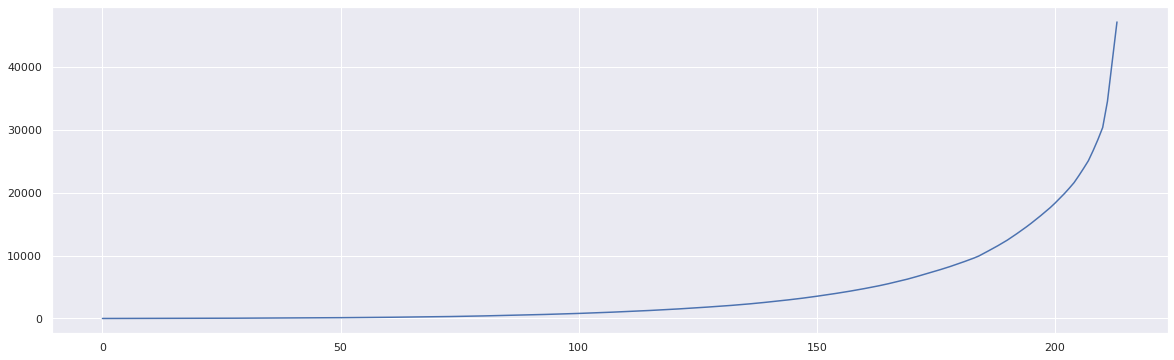

In [106]:
fig = plt.figure(figsize=(20, 6))
y = []
for i in range(len(bc)):
  y.append(bc.tail(i)['sum'].sum())
x = range(len(bc))
plt.plot(x, y)
plt.gca()

##### Concat Cat and Dog

In [107]:
adoption_df = adoption_df[(adoption_df['breed'].notnull()) & (~adoption_df['breed'].isin(['unknown', 'mix']))]

In [108]:
import re
adoption_df.loc[adoption_df['animal_type'] == 'cat', 'breed'] = \
  adoption_df[adoption_df['animal_type'] == 'cat']['breed'].apply(lambda x: re.sub(r' sh$', ' shorthair', x.replace(' mix', '').replace('/mix', '')
  .replace('/unknown', '').replace('sh/', 'shorthair/').replace('dsh', 'domestic shorthair')
  .replace('domestic short hair', 'domestic shorthair').replace('dlh', 'domestic long hair')
  .replace('domestic lh', 'domestic long hair').replace('domestic longhair', 'domestic long hair')
  .replace('dmh', 'domestic medium hair').replace('domestic mh', 'domestic medium hair'))
  .replace('curl shorthair', 'curl').replace('munchkin longhair', 'munchkin')
  .replace('munchkin shorthair', 'munchkin').replace('pixie-bob', 'pixiebob')
  .replace('pixiebob shorthair', 'pixiebob'))

adoption_df.loc[adoption_df['animal_type'] == 'cat', 'breed'] = \
  adoption_df[adoption_df['animal_type'] == 'cat']['breed'].replace({'angora': 'turkish angora'})
adoption_df.loc[adoption_df['animal_type'] == 'cat', 'breed'] = \
  adoption_df[adoption_df['animal_type'] == 'cat']['breed'].apply(merge_other_cb)

In [109]:
adoption_df.loc[adoption_df['animal_type'] == 'dog', 'breed'] = \
  adoption_df[adoption_df['animal_type'] == 'dog']['breed'].apply(clean_dog_breed)
adoption_df.loc[adoption_df['animal_type'] == 'dog', 'breed'] = \
  adoption_df[adoption_df['animal_type'] == 'dog']['breed'].apply(merge_other_db)

In [110]:
adoption_df['breed'].unique()

array(['other dog breed', 'dachshund/border terrier',
       'anatolian shepherd/labrador retriever', ...,
       'parson russell terrier/pug', 'siberian husky/poodle',
       'australian shepherd/pit bull'], dtype=object)

In [111]:
adoption_df = pd.concat([adoption_df, adoption_df['breed'].str.get_dummies(sep='/')], axis=1)

### Numerical Data Analysis & Preprocessing

In [112]:
print(adoption_df.columns)

Index(['animal_id', 'name', 'intake_date', 'outcome_date', 'outcome_type',
       'outcome_subtype', 'animal_type', 'breed', 'color', 'age_in_days',
       ...
       'shepherd', 'shih tzu', 'siamese', 'siberian husky', 'snowshoe',
       'staffordshire bull terrier', 'tonkinese', 'turkish angora',
       'turkish van', 'yorkshire terrier'],
      dtype='object', length=141)


In [113]:
# Find out numerical columns
numeric_columns = adoption_df.select_dtypes(include=[np.number]).columns
numeric_columns

Index(['age_in_days', 'cost', 'days_in_shelter', 'if_neutered_or_spayed',
       'gender', 'apricot', 'black', 'blue', 'brindle', 'brown',
       ...
       'shepherd', 'shih tzu', 'siamese', 'siberian husky', 'snowshoe',
       'staffordshire bull terrier', 'tonkinese', 'turkish angora',
       'turkish van', 'yorkshire terrier'],
      dtype='object', length=132)

The `dats_in_shelter` fields calculated the `intake_date` and `outcome_date`. Let's validate the results.

In [114]:
# Validate the calculated days in shelter
def validate_days(df):
  df['validate_days'] = df['outcome_date'] - df['intake_date']
  df['validate_days'] = df['validate_days'].apply(lambda x : x / datetime.timedelta(days=1))
  print(df[df['validate_days'] != df['days_in_shelter']])


validate_days(adoption_df)

       animal_id          name intake_date outcome_date outcome_type  \
144647     47639        Apollo  2017-03-11   2017-04-02     adoption   
144742     47771         Chica  2017-03-28   2017-04-10     adoption   
144758     47558         Clyde  2017-03-06   2017-04-12     adoption   
145003     47770        Little  2017-03-28   2017-05-07     adoption   
145018     31469        Bonnie  2013-03-26   2017-05-09     adoption   
...          ...           ...         ...          ...          ...   
166800     74466      Ms. Lola  2022-09-06   2022-11-03     adoption   
166812     74375  Garth Brooks  2022-08-27   2022-11-04     adoption   
166822     72682         Spyro  2022-03-15   2022-11-04     adoption   
166826     72378        Medusa  2022-02-01   2022-11-05     adoption   
166835     74126           Roz  2022-08-04   2022-11-06     adoption   

       outcome_subtype animal_type                            breed  \
144647             NaN         dog        labrador retriever/col

We notice that there are some entries with `days_in_shelter` being null. This because when processing one of our dataset (Bloomington) data, we notice that there might be multiple outcome_date associate with one intake_date for the same entry (with the same animal ID), which should be considered as invalid data. After discussion, we have decided to keep the first recorded entry of ourcome date and ignore the rest when calculating `days_in_shelter`, which will remain those entries having a NULL `days_in_shelter`  value. As they are invalid entries, we should remove them.

In [115]:
adoption_df = adoption_df[adoption_df['days_in_shelter'].isnull() == False]

In [116]:
# Validate days in shelter again, and drop the added `validate_days` column
validate_days(adoption_df)
adoption_df = adoption_df.drop(columns=["validate_days"])

<ipython-input-114-58b89130b3fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['validate_days'] = df['outcome_date'] - df['intake_date']


Empty DataFrame
Columns: [animal_id, name, intake_date, outcome_date, outcome_type, outcome_subtype, animal_type, breed, color, age_in_days, cost, days_in_shelter, if_neutered_or_spayed, gender, apricot, black, blue, brindle, brown, buff, calico, choc, cream, dilute, fawn, flame, gold, grey, lilac, liver, lynx, merle, orange, other_color, point, red, sable, seal, silver, smoke, tabbico, tabby, tan, tick, tiger, torbie, torti, tortoiseshell, white, yellow, abyssinian, alaskan husky, american bulldog, american curl, american pit bull terrier, american shorthair, american staffordshire terrier, anatolian shepherd, australian cattle, australian kelpie, australian shepherd, balinese, basset hound, beagle, belgian shepherd, bengal, black and tan coonhound, black mouth cur, blue lacy, bombay, border terrier, boxer, british shorthair, bully breed, burmese, cairn terrier, calico, catahoula leopard, chihuahua, chinese sharpei, chow chow, collie, corgi, cymric, dachshund, devon rex, doberman pins

Let's also visualize the number of adoptions over time (monthly data).

Text(0.5, 1.0, 'Adoption Count Over Time (Monthly)')

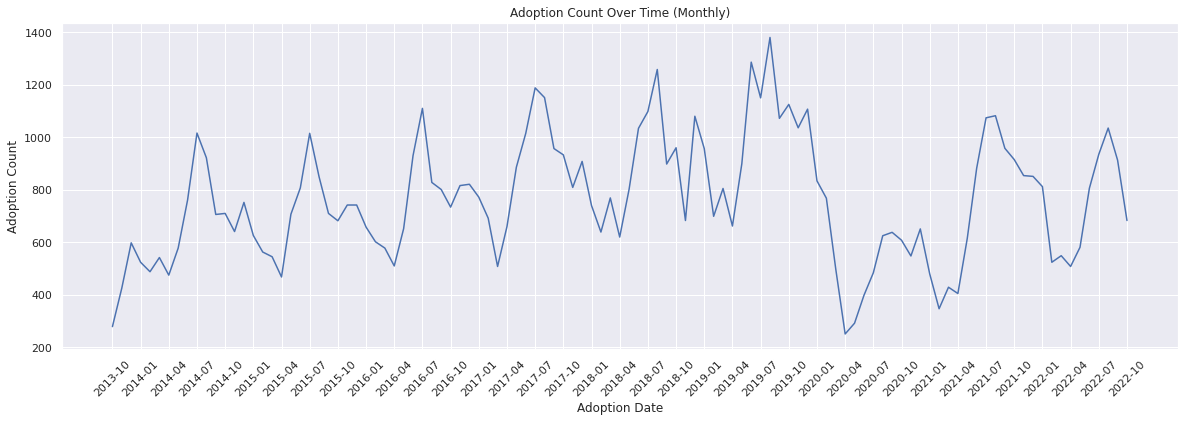

In [117]:
fig = plt.figure(figsize=(20, 6))
monthyear = adoption_df.groupby(by=[adoption_df.outcome_date.dt.year, adoption_df.outcome_date.dt.month])['animal_id'].count().iloc[1:-1]
ax = monthyear.plot()
ax.set_xticks(range(len(monthyear))[0::3]);
ax.set_xticklabels(["%s-%02d" % item for item in monthyear.index.tolist()[0::3]], rotation=45)
ax.set_xlabel('Adoption Date')
ax.set_ylabel('Adoption Count')
ax.set_title('Adoption Count Over Time (Monthly)')

### Process NULL values
We have done some filtering of our data, and let's take a look at NULL and zero values.

In [118]:
# Check percentage of null values of selected features
def NullPercentage(df):
  print(df.apply(lambda col : col.isnull().sum()/len(col)))

In [119]:
NullPercentage(adoption_df)

animal_id                     0.000000
name                          0.129883
intake_date                   0.000000
outcome_date                  0.000000
outcome_type                  0.000000
                                ...   
staffordshire bull terrier    0.000000
tonkinese                     0.000000
turkish angora                0.000000
turkish van                   0.000000
yorkshire terrier             0.000000
Length: 141, dtype: float64


We see there are a few fields with more than 10% of values being null, among which the `outcome_subtype` field has a large amount of values being NULL. **This is somewhat expected, as the `adoption_df` only contains animals that ended up being adopted, and `outcome_subtype` usually records some additional information for outcomes if needed.** Regardless, let's take a closer look into this field.

In [120]:
adoption_df['outcome_subtype'].value_counts(normalize=True)

foster        0.647257
walkin        0.153724
scas web      0.062045
internet      0.039645
offsite       0.022796
westfarm      0.022300
referral      0.013033
spec event    0.008722
referral-o    0.004460
49er pet      0.004113
finder        0.004014
mob event     0.003073
fb scas       0.003073
volunteer     0.002973
referral-f    0.002726
referral-v    0.002081
oth_media     0.000842
facebook      0.000743
debbie btq    0.000743
ad nwspapr    0.000496
rescue grp    0.000496
advert        0.000198
instagram     0.000149
barn          0.000149
fb other      0.000099
ad radio      0.000050
Name: outcome_subtype, dtype: float64

Noticed that `foaster` takes up >60% of `outcome_subtype`. This provides an important information, as fostered animals are **temporarily adopted** by people and will be **returned to the shelter later**. We need to filter out these entries. Other `outcome_subtype` seems to mostly record where and how animals are being adopted, and we can drop this field after filtering.

In [121]:
adoption_df = adoption_df[adoption_df['outcome_subtype'] != 'foster']
adoption_df = adoption_df.drop(columns=['outcome_subtype'])

In [122]:
adoption_df = adoption_df[adoption_df['age_in_days'].notnull()]

Check the NULL percentage again after filtering. 

In [123]:
NullPercentage(adoption_df)

animal_id                     0.000000
name                          0.128017
intake_date                   0.000000
outcome_date                  0.000000
outcome_type                  0.000000
                                ...   
staffordshire bull terrier    0.000000
tonkinese                     0.000000
turkish angora                0.000000
turkish van                   0.000000
yorkshire terrier             0.000000
Length: 140, dtype: float64


After filtering out fostered animals, we see there most of the entries are not NULL except for neuter/spay information, and name. Although `name` is less important for our model training, animal's neuter/spay information could potentially affect people's adoption choices. However, this information along with animal gender can be hard to keep track sometimes by the shelters, and will need to be properly addressed during feature engineering.

The final size of our dataframe is:

In [124]:
adoption_df.shape

(70022, 140)

In [125]:
adoption_df.to_csv('adoption.csv', index=False)

### Correlation Analysis (postpone after encoding)

In [126]:
# Initialize correlation matrix
corr_matrix = adoption_df.corr()

Plot the correlation heatmap. -1 correlation represents the darkest red color, 0 is totally white, and +1 correlation is the blue color

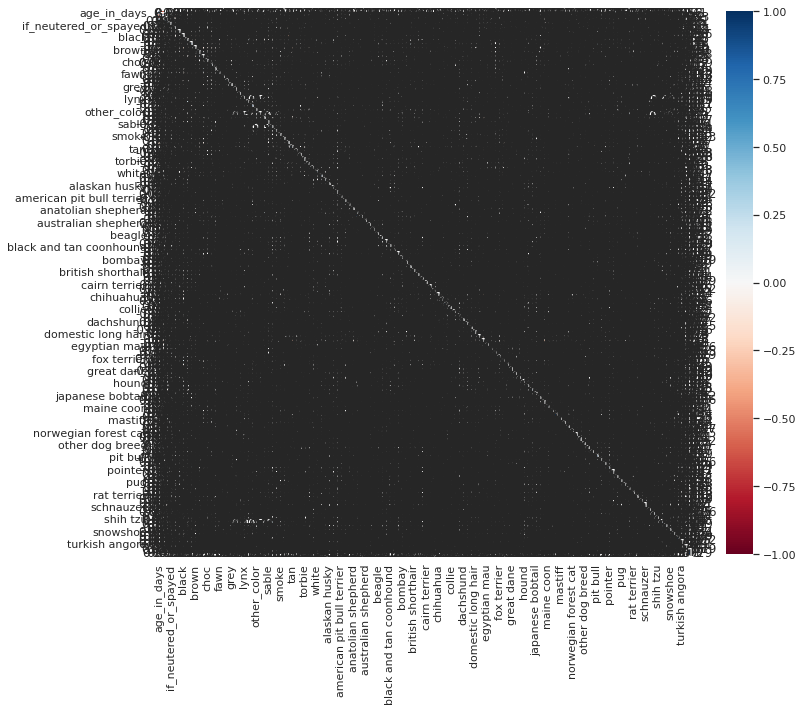

In [127]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='RdBu', annot=True, norm=plt.Normalize(-1.0, 1.0))

#**Feature Engineering**

####One-hot encode

In [128]:
adoption_df.columns

Index(['animal_id', 'name', 'intake_date', 'outcome_date', 'outcome_type',
       'animal_type', 'breed', 'color', 'age_in_days', 'cost',
       ...
       'shepherd', 'shih tzu', 'siamese', 'siberian husky', 'snowshoe',
       'staffordshire bull terrier', 'tonkinese', 'turkish angora',
       'turkish van', 'yorkshire terrier'],
      dtype='object', length=140)

We can drop columns that are not being used (for instance `animal_id`, `name`, `intake_date` and `outcome_date` which are already used for calculating the label) or have single values (`outcome_type`)

In [129]:
adoption_df = pd.get_dummies(adoption_df, columns=['animal_type', 'gender', 'if_neutered_or_spayed'])

In [130]:
adoption_training_df = adoption_df.drop(columns=['animal_id', 'name', 'intake_date', 'outcome_date', 'outcome_type', 'breed', 'color'])

In [131]:
adoption_training_df.shape

(70022, 136)

####Analysis and helper functions

Take a look at the days in shelter and cost distribution

In [132]:
adoption_training_df['cost'].describe()

count    70022.000000
mean        82.060765
std         24.617897
min          0.000000
25%         80.000000
50%         80.000000
75%         80.000000
max        192.030000
Name: cost, dtype: float64

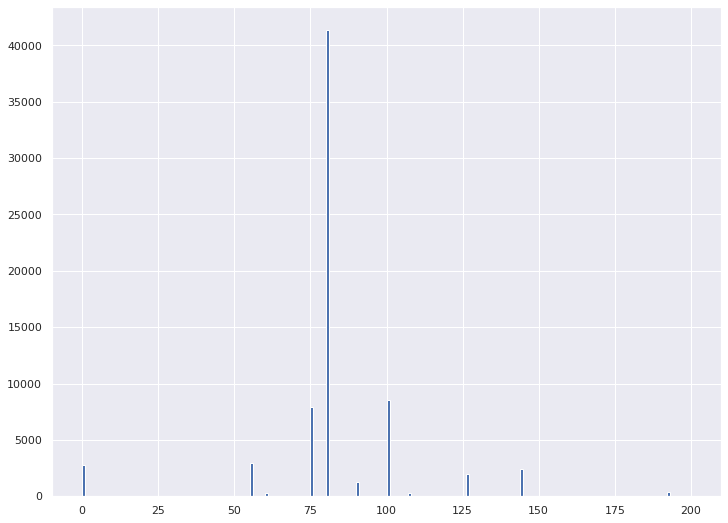

In [133]:
cost_hist = adoption_training_df['cost'].hist(bins=200, range=[0, 200])

count    70022.000000
mean       770.553455
std        958.562757
min         14.000000
25%        111.000000
50%        375.000000
75%       1055.000000
max      12516.000000
Name: age_in_days, dtype: float64


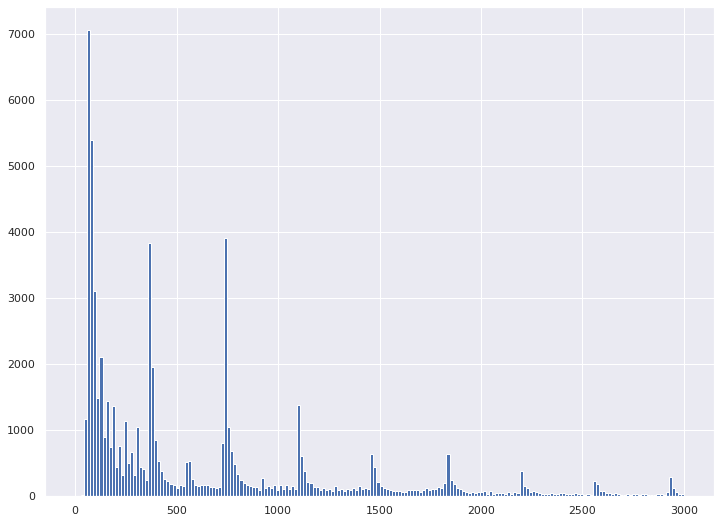

In [134]:
print(adoption_training_df['age_in_days'].describe())
age_hist = adoption_training_df['age_in_days'].hist(bins=200, range=[0, 3000])

In [135]:
adoption_training_df['days_in_shelter'].describe()

count    70022.000000
mean        24.269044
std         41.552479
min          0.000000
25%          5.000000
50%         11.000000
75%         30.000000
max       2723.000000
Name: days_in_shelter, dtype: float64

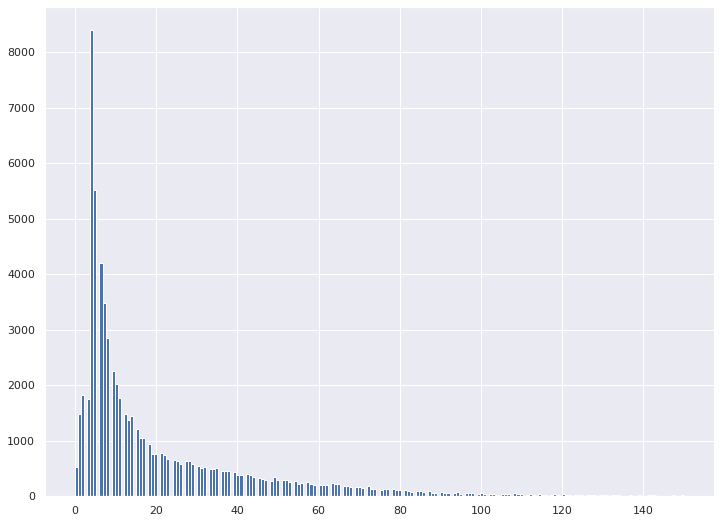

In [136]:
hist = adoption_training_df['days_in_shelter'].hist(bins=200, range=[0, 150])

In [137]:
percentile = np.arange(1, 21, 1)

In [138]:
percentile = percentile* 0.05

In [139]:
adoption_training_df['days_in_shelter'].describe(percentiles=percentile)

count    70022.000000
mean        24.269044
std         41.552479
min          0.000000
5%           2.000000
10%          4.000000
15%          4.000000
20%          5.000000
25%          5.000000
30%          6.000000
35%          7.000000
40%          8.000000
45%          9.000000
50%         11.000000
55%         13.000000
60%         16.000000
65%         20.000000
70%         24.000000
75%         30.000000
80%         37.000000
85%         46.000000
90%         60.000000
95%         81.000000
100%      2723.000000
max       2723.000000
Name: days_in_shelter, dtype: float64

In [140]:
def map_days_to_period(days):
  if days >= 0 and days < 5:
    return "short[0, 5)"
  elif days >= 5 and days < 11:
    return "med[5, 11)"
  elif days >= 11 and days < 30:
    return "long[11, 30)"
  else:
    return "very long(30+)"

In [141]:
adoption_training_df.skew().sort_values(ascending=False)

cymric                       264.616704
javanese                     152.769979
egyptian mau                 152.769979
pixiebob                     152.769979
exotic shorthair             132.299849
                                ...    
white                          0.203210
gender_0.0                    -0.025309
cost                          -0.216250
animal_type_dog               -0.288294
if_neutered_or_spayed_1.0     -1.296583
Length: 136, dtype: float64

In [142]:
labels = ["short[0, 5)", "med[5, 11)", "long[11, 30)", "very long(30+)"]

####Helper Function for Obtaining Dataset

In [143]:
dog_only_cols = ['apricot',
 'liver',
 'merle',
 'sable',
 'alaskan husky',
 'american bulldog',
 'american pit bull terrier',
 'american staffordshire terrier',
 'anatolian shepherd',
 'australian cattle',
 'australian kelpie',
 'australian shepherd',
 'basset hound',
 'beagle',
 'belgian shepherd',
 'black and tan coonhound',
 'black mouth cur',
 'blue lacy',
 'border terrier',
 'boxer',
 'bully breed',
 'cairn terrier',
 'catahoula leopard',
 'chihuahua',
 'chinese sharpei',
 'chow chow',
 'collie',
 'corgi',
 'dachshund',
 'doberman pinscher',
 'fox terrier',
 'german shepherd',
 'golden retriever',
 'great dane',
 'great pyrenees',
 'hound',
 'husky',
 'jack russell terrier',
 'labrador retriever',
 'maltese',
 'mastiff',
 'miniature pinscher',
 'other dog breed',
 'parson russell terrier',
 'pit bull',
 'plott hound',
 'pointer',
 'pomeranian',
 'poodle',
 'pug',
 'queensland heeler',
 'rat terrier',
 'rottweiler',
 'schnauzer',
 'shepherd',
 'shih tzu',
 'siberian husky',
 'staffordshire bull terrier',
 'yorkshire terrier',
 'animal_type_dog',
 'animal_type_cat']

In [144]:
cat_only_cols = ['dilute',
 'flame',
 'lynx',
 'seal',
 'tabbico',
 'tabby',
 'torbie',
 'torti',
 'tortoiseshell',
 'abyssinian',
 'american curl',
 'american shorthair',
 'balinese',
 'bengal',
 'bombay',
 'british shorthair',
 'burmese',
 'calico',
 'cymric',
 'devon rex',
 'domestic long hair',
 'domestic medium hair',
 'domestic shorthair',
 'egyptian mau',
 'exotic shorthair',
 'extra-toes cat (hemingway polydactyl)',
 'himalayan',
 'japanese bobtail',
 'javanese',
 'maine coon',
 'manx',
 'munchkin',
 'norwegian forest cat',
 'oriental shorthair',
 'other cat breed',
 'persian',
 'pixiebob',
 'ragdoll',
 'russian blue',
 'scottish fold',
 'siamese',
 'snowshoe',
 'tonkinese',
 'turkish angora',
 'turkish van',
 'animal_type_cat',
 'animal_type_dog']

In [145]:
def GetDataSet(data, has_all, dog_only, cat_only, categorical, cate_func):
  if dog_only:
    ret = data[data['animal_type_dog'] == 1].copy()
    ret = ret.drop(columns=cat_only_cols)
  elif cat_only:
    ret = data[data['animal_type_cat'] == 1].copy()
    ret = ret.drop(columns=dog_only_cols)
  elif has_all:
    ret = data.copy()
  
  if categorical:
    ret['days_in_shelter'] = ret['days_in_shelter'].apply(cate_func)
  
  return ret

In [146]:
def log_transform(data):
  return np.log(data + 1)

In [147]:
# example 
# dogs_df = GetDataSet(data=adoption_training_df, has_all=False, dog_only=True, cat_only=False, categorical=True, cate_func=map_days_to_period_less)

In [148]:
# adoption_training_leveled_df = adoption_training_df.copy()
# adoption_training_leveled_df['days_in_shelter'] = adoption_training_leveled_df['days_in_shelter'].apply(map_days_to_period_less)
# adoption_dog_leveled_df = adoption_dog_df.copy()
# adoption_dog_leveled_df['days_in_shelter'] = adoption_dog_leveled_df['days_in_shelter'].apply(map_days_to_period_less)
# adoption_cat_leveled_df = adoption_cat_df.copy()
# adoption_cat_leveled_df['days_in_shelter'] = adoption_cat_leveled_df['days_in_shelter'].apply(map_days_to_period_less)

#**Model Training**

### Model Implementation

#### Logistic Regression 

In [149]:
def LogisticRegressionRunner(x_train, y_train, x_test, y_test, max_iter=3000):
  clf = LogisticRegression(random_state=0, max_iter=max_iter).fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print('LogisticRegression train accuracy score is: %.4f' %clf.score(x_train, y_train))
  print('LogisticRegression cross validation score is: %.4f' % cross_val_score(clf, x_train, y_train, cv=5).mean())
  print('LogisticRegression test accuracy score is: %.4f' %clf.score(x_test, y_test))

  # Print report from Confusion Matrix
  cm = confusion_matrix(y_test, y_pred, labels=labels)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, cmap=sns.diverging_palette(200, 20, as_cmap=True), fmt='d')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Ground Truth')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  print('LogisticRegression classification report:\n', classification_report(y_test,y_pred))
  return clf, y_pred

#### Random Forest Classification



In [150]:
def RandomForestClassifierRunner(x_train, y_train, x_test, y_test, max_depth=18): 
  clf = RandomForestClassifier(max_depth=max_depth, random_state=0, min_samples_split=2)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print('RandomForestClassifier train accuracy score is: %.4f' %clf.score(x_train, y_train))
  print('RandomForestClassifier cross validation score is: %.4f' % cross_val_score(clf, x_train, y_train, cv=5).mean())
  print('RandomForestClassifier accuracy score is: %.4f' %clf.score(x_test, y_test))

  # Confusion Matrix and F1 scores
  cm = confusion_matrix(y_test, y_pred, labels=labels)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, cmap=sns.diverging_palette(200, 20, as_cmap=True), fmt='d')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Ground Truth')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  print('RandomForestClassifier classification report:\n', classification_report(y_test,y_pred))
  return clf, y_pred

####XGBClassifier

In [151]:
from xgboost import XGBClassifier

def XGBClassifierRunner(x_train, y_train, x_test, y_test, objective='multi:softmax', num_class=4, max_depth=8):
  xgb = XGBClassifier(objective=objective, num_class=num_class, max_depth=max_depth)
  xgb.fit(x_train, y_train)
  y_pred = xgb.predict(x_test)
  print('XGBClassifier train accuracy score is: %.4f' %xgb.score(x_train, y_train))
  print('XGBClassifier cross validation score is: %.4f' % cross_val_score(xgb, x_train, y_train, cv=5).mean())
  print('XGBClassifier accuracy score is: %.4f' %xgb.score(x_test, y_test))

  # Confusion Matrix and F1 scores
  cm = confusion_matrix(y_test, y_pred, labels=labels)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, cmap=sns.diverging_palette(200, 20, as_cmap=True), fmt='d')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Ground Truth')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  print('XGBClassifier classification report:\n', classification_report(y_test,y_pred))
  return xgb, y_pred

####MLP Classifier

In [152]:
from sklearn.neural_network import MLPClassifier

def MLPClassifierRunner(x_train, y_train, x_test, y_test, hidden_layer_sizes=(64, 32), max_iter=5000): 
  clf = MLPClassifier(solver='lbfgs', alpha=1e-5, batch_size=128, hidden_layer_sizes=hidden_layer_sizes, early_stopping=True)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print('MLPClassifier accuracy score is: %.4f' %clf.score(x_test, y_test))

  # Confusion Matrix and F1 scores
  cm = confusion_matrix(y_test, y_pred, labels=labels)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, cmap=sns.diverging_palette(200, 20, as_cmap=True), fmt='d')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Ground Truth')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  print('MLPClassifier classification report:\n', classification_report(y_test,y_pred))
  return clf, y_pred

####KNN Classifier

In [153]:
from sklearn.neighbors import KNeighborsClassifier

def KnnClassifierRunner(x_train, y_train, x_test, y_test, n_neighbors=500): 
  clf = KNeighborsClassifier(n_neighbors=n_neighbors)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print('KnnClassifier accuracy score is: %.4f' %clf.score(x_test, y_test))

  # Confusion Matrix and F1 scores
  cm = confusion_matrix(y_test, y_pred, labels=labels)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, cmap=sns.diverging_palette(200, 20, as_cmap=True), fmt='d')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Ground Truth')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  print('KnnClassifier classification report:\n', classification_report(y_test,y_pred))
  return clf, y_pred

#### Ridge (L2 Linear) Regression

In [154]:
def RidgeRunner(x_train, y_train, x_test, y_test, alpha=0.5):
  ridge_reg = Ridge(alpha = alpha)
  ridge_reg = ridge_reg.fit(x_train, y_train) 
  y_pred = ridge_reg.predict(x_test)
  print('L2 LinearRegression score is: %.3f' %ridge_reg.score(x_test, y_test))
  mse = mean_squared_error(y_test, y_pred)
  print('L2 LinearRegression MSE: %.3f' %mse)
  mae = mean_absolute_error(y_test, y_pred)
  print('L2 LinearRegression MAE: %.3f' %mae)

  plt.figure(figsize=(16, 10))
  plt.title("L2 LinearRegression Predictions vs Ground Truth")
  plt.scatter(range(0, len(y_test)), y_test, marker='.', label='Ground Truth')
  plt.scatter(range(0, len(y_pred)), pd.Series(y_pred), marker='+', label='Predictions')
  plt.legend()
  plt.show()

  y_train_pred = ridge_reg.predict(x_train)
  plt.figure(figsize=(16, 10))
  plt.title("LinearRegression Training Prediction vs Ground Truth")
  plt.scatter(range(0, len(y_train)), y_train, marker='+', label='Ground Truth')
  plt.scatter(range(0, len(y_train_pred)), pd.Series(y_train_pred), marker='.', label='Prediction')
  plt.legend()
  plt.show()

  prediction_and_truth_diff = y_test.subtract(pd.Series(y_pred))
  print("L2 LinearRegression prediction vs truth difference:\n", prediction_and_truth_diff.describe())

  plt.figure(figsize=(16, 10))
  plt.title("L2 LinearRegression Prediction vs Ground Truth Difference Plot")
  plt.plot(prediction_and_truth_diff, marker='.')
  plt.show()


  return ridge_reg, y_pred

#### RandomForestRegressor

In [155]:
def RandomForestRegressorRunner(x_train, y_train, x_test, y_test, max_depth=18, n_estimatiors=5000, criterion='squared_error'):
  rf_reg = RandomForestRegressor(n_estimators=n_estimatiors, bootstrap=True, max_features = 'sqrt', max_depth=max_depth, random_state=0, criterion=criterion)
  rf_reg.fit(x_train, y_train)
  y_pred = rf_reg.predict(x_test)
  print('RandomForestRegressor score is: %.4f' %rf_reg.score(x_test, y_test))
  mse = mean_squared_error(y_test, y_pred)
  print('RandomForestRegressor MSE: %.4f' %mse)
  mae = mean_absolute_error(y_test, y_pred)
  print('RandomForestRegressor MAE: %.4f' %mae)

  plt.figure(figsize=(16, 10))
  plt.title("RandomForestRegressor Predictions vs Ground Truth")
  plt.scatter(range(0, len(y_test)), y_test, marker='.', label='Ground Truth')
  plt.scatter(range(0, len(y_pred)), pd.Series(y_pred), marker='+', label='Prediction')
  plt.legend()
  plt.show()

  y_train_pred = rf_reg.predict(x_train)
  plt.figure(figsize=(16, 10))
  plt.title("RandomForestRegressor Training Prediction vs Ground Truth")
  plt.scatter(range(0, len(y_train)), y_train, marker='+', label='Ground Truth')
  plt.scatter(range(0, len(y_train_pred)), pd.Series(y_train_pred), marker='.', label='Prediction')
  plt.legend()
  plt.show()

  prediction_and_truth_diff = y_test.subtract(pd.Series(y_pred))
  print("RandomForestRegressor prediction vs truth difference:\n", prediction_and_truth_diff.describe())

  plt.figure(figsize=(16, 10))
  plt.title("RandomForestRegressor Prediction vs Ground Truth Difference Plot")
  plt.plot(prediction_and_truth_diff, marker='.')
  plt.show()

  return rf_reg, y_pred

### Train Test Split

In [156]:
def standard_scale_data(x_train, x_test):
  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_test = scaler.transform(x_test)
  return x_train, x_test

In [157]:
def train_test_split_helper(data, label_col, test_size = 0.2):
  y = data[label_col]
  X = data.copy()
  X = X.drop(columns=[label_col])

  return train_test_split(X, y, test_size = test_size, random_state=42)

###Model Training, Prediction, and Analysis

####Both Dogs and Cats

#####**Regression without log transform**

In [158]:
all_reg_df = GetDataSet(data=adoption_training_df, has_all=True, dog_only=False, cat_only=False, categorical=False, cate_func=map_days_to_period)

In [159]:
ar_x_train, ar_x_test, ar_y_train, ar_y_test = train_test_split_helper(all_reg_df, label_col='days_in_shelter')

In [160]:
ar_x_train, ar_x_test = standard_scale_data(ar_x_train, ar_x_test)

######**Ridge**

L2 LinearRegression score is: 0.092
L2 LinearRegression MSE: 1495.601
L2 LinearRegression MAE: 19.471


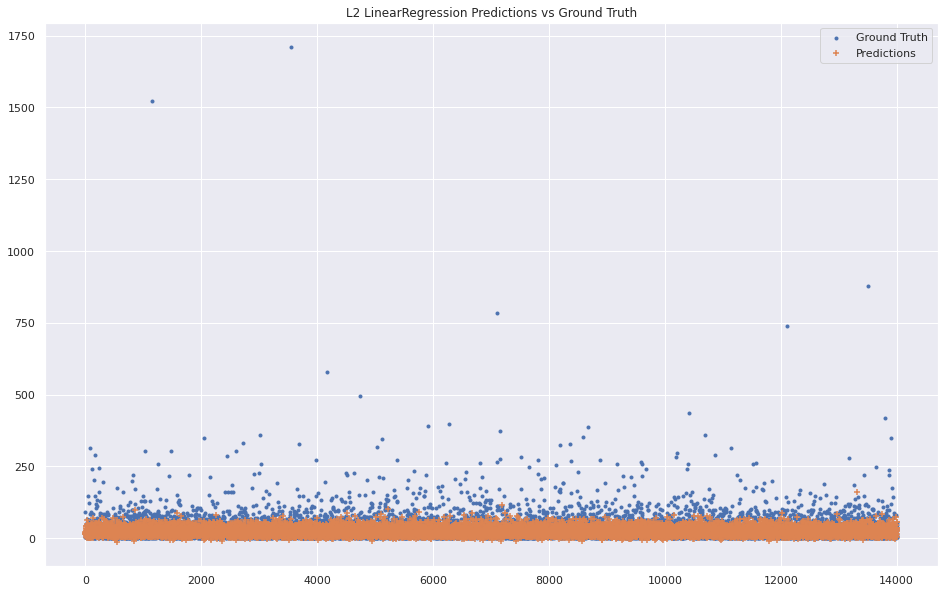

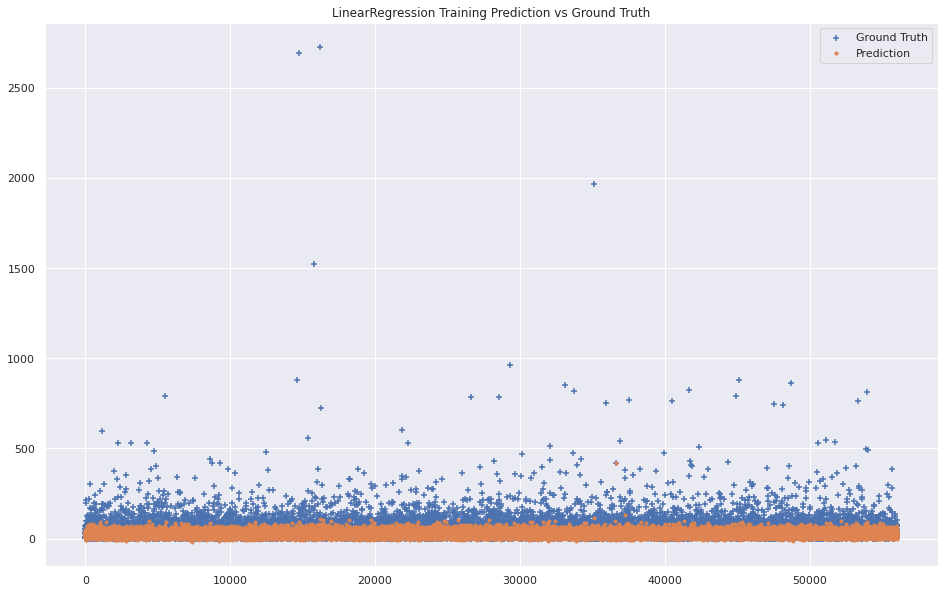

L2 LinearRegression prediction vs truth difference:
 count    872.000000
mean      -7.174451
std       27.191448
min     -156.027998
25%      -22.344916
50%      -10.361911
75%        1.897330
max      152.803767
dtype: float64


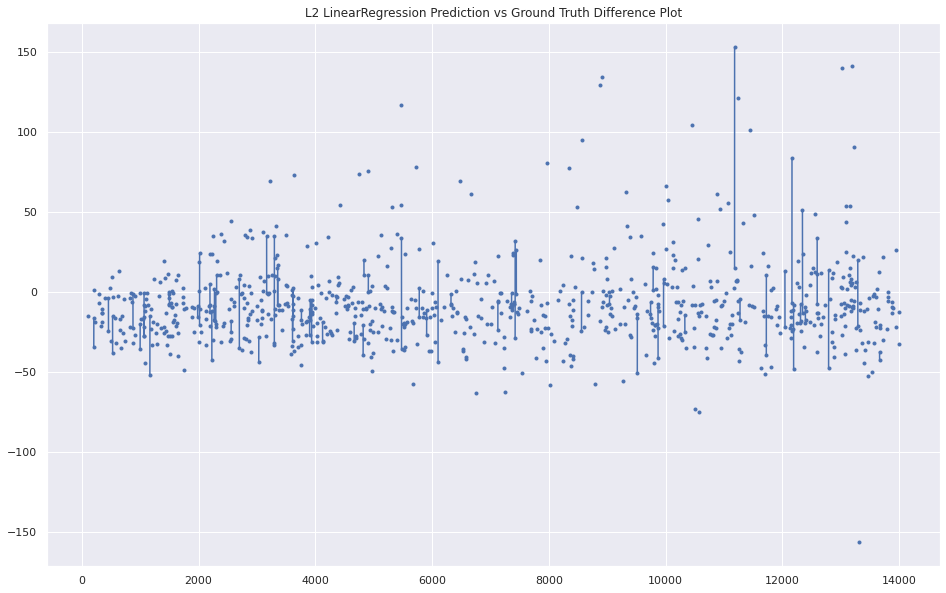

In [161]:
ridge, ridge_y_pred = RidgeRunner(ar_x_train, ar_y_train, ar_x_test, ar_y_test)

######**RandomForestRegressor**

RandomForestRegressor score is: 0.0394
RandomForestRegressor MSE: 1581.6329
RandomForestRegressor MAE: 18.2625


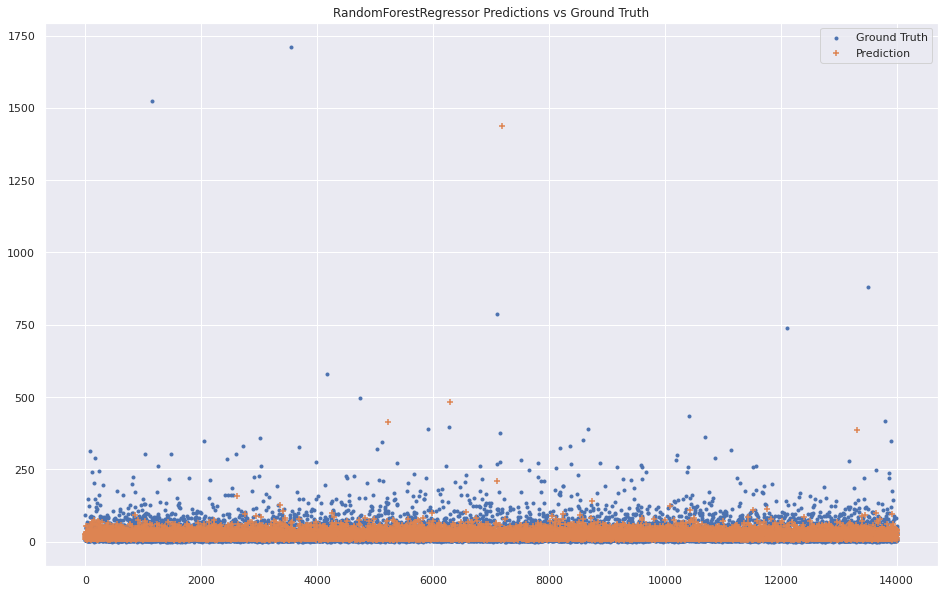

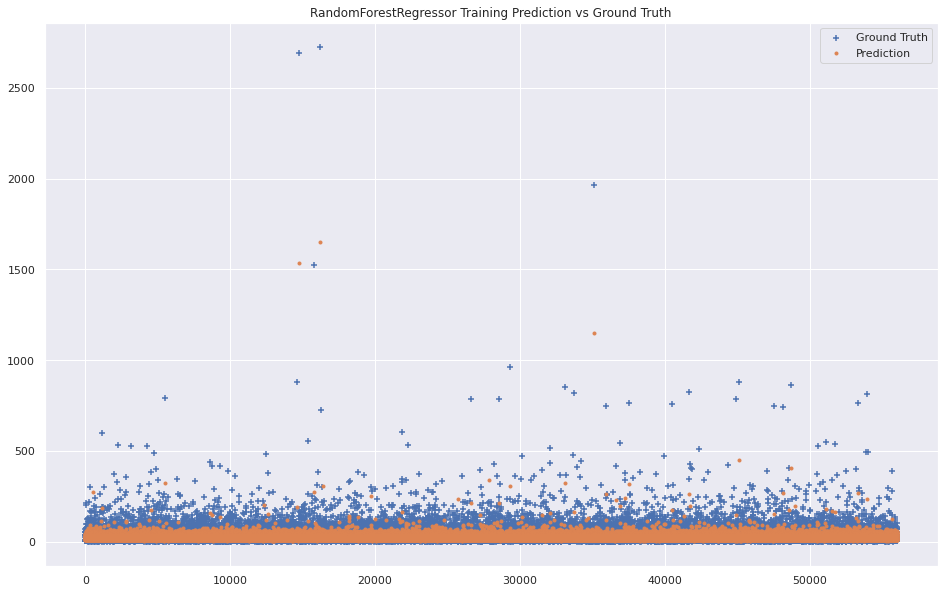

RandomForestRegressor prediction vs truth difference:
 count    872.000000
mean      -7.062514
std       29.510776
min     -380.514630
25%      -20.862813
50%      -10.277476
75%       -0.210511
max      159.609966
dtype: float64


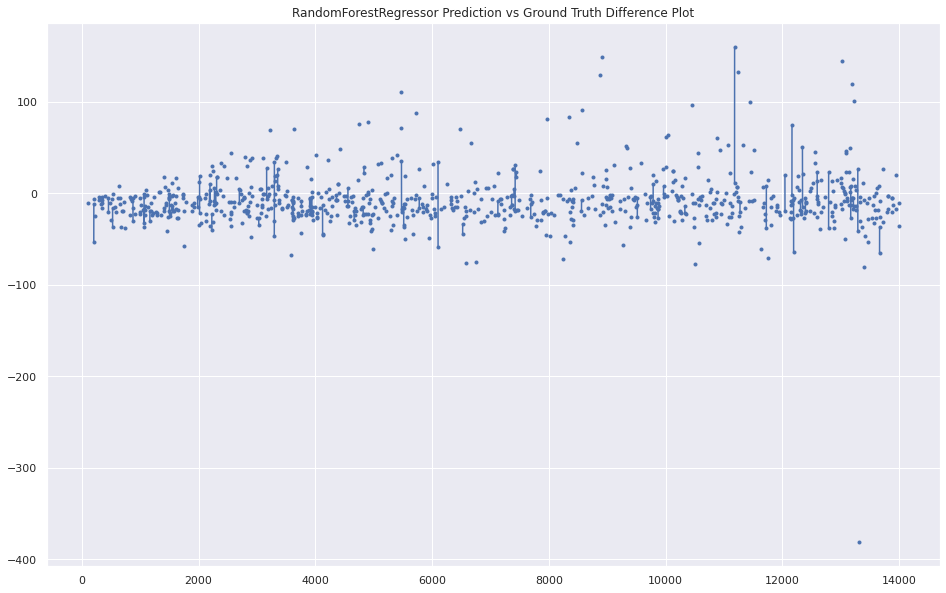

In [162]:
rf_reg, rf_reg__y_pred = RandomForestRegressorRunner(ar_x_train, ar_y_train, ar_x_test, ar_y_test)

#####**Regression with log transform**

In [163]:
all_reg_df = GetDataSet(data=adoption_training_df, has_all=True, dog_only=False, cat_only=False, categorical=False, cate_func=map_days_to_period)

In [164]:
ar_x_train, ar_x_test, ar_y_train, ar_y_test = train_test_split_helper(all_reg_df, label_col='days_in_shelter')

In [165]:
ar_x_train, ar_x_test = standard_scale_data(ar_x_train, ar_x_test)

In [166]:
ar_y_train = log_transform(ar_y_train)
ar_y_test = log_transform(ar_y_test)

######**Ridge**

L2 LinearRegression score is: 0.222
L2 LinearRegression MSE: 0.854
L2 LinearRegression MAE: 0.733


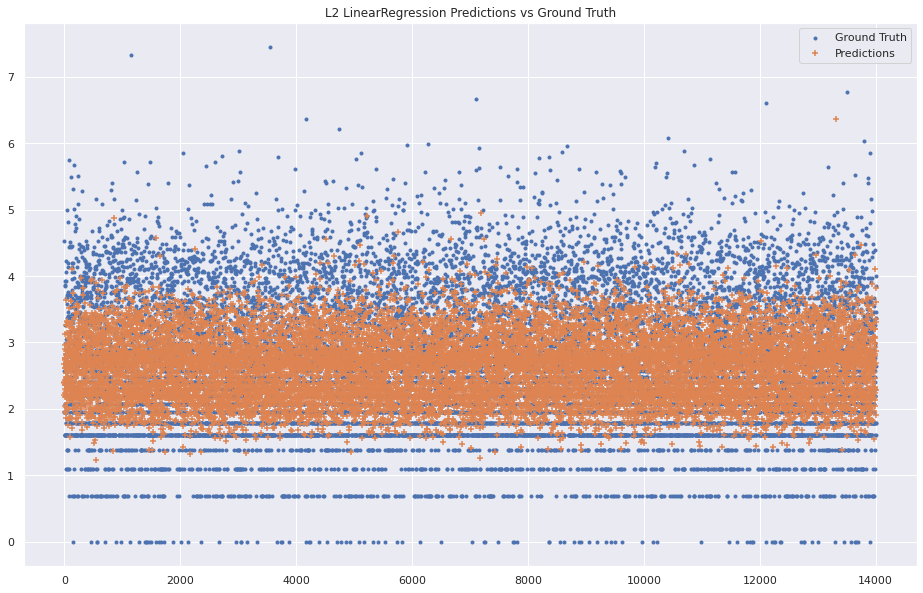

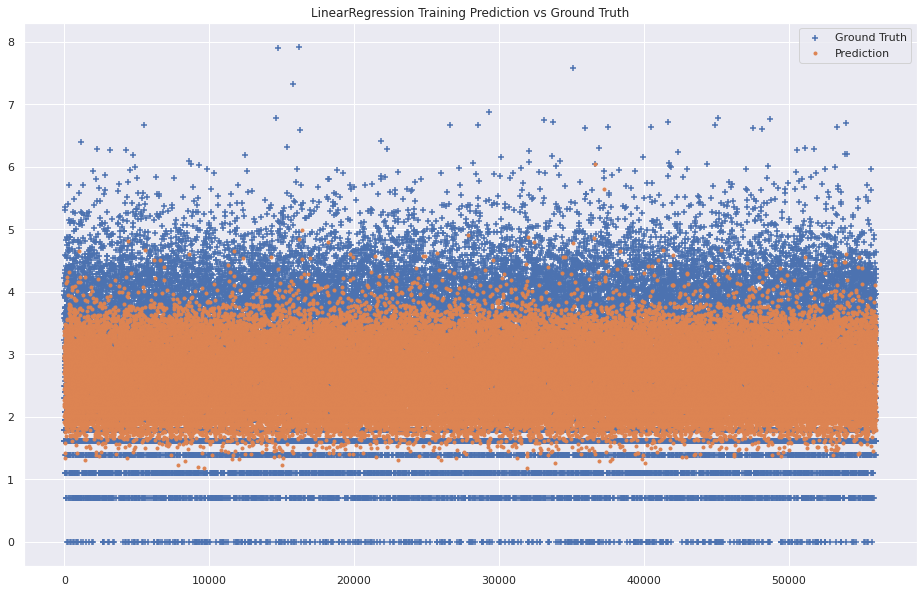

L2 LinearRegression prediction vs truth difference:
 count    872.000000
mean      -0.243707
std        1.063001
min       -4.414667
25%       -0.989139
50%       -0.394622
75%        0.457928
max        2.767493
dtype: float64


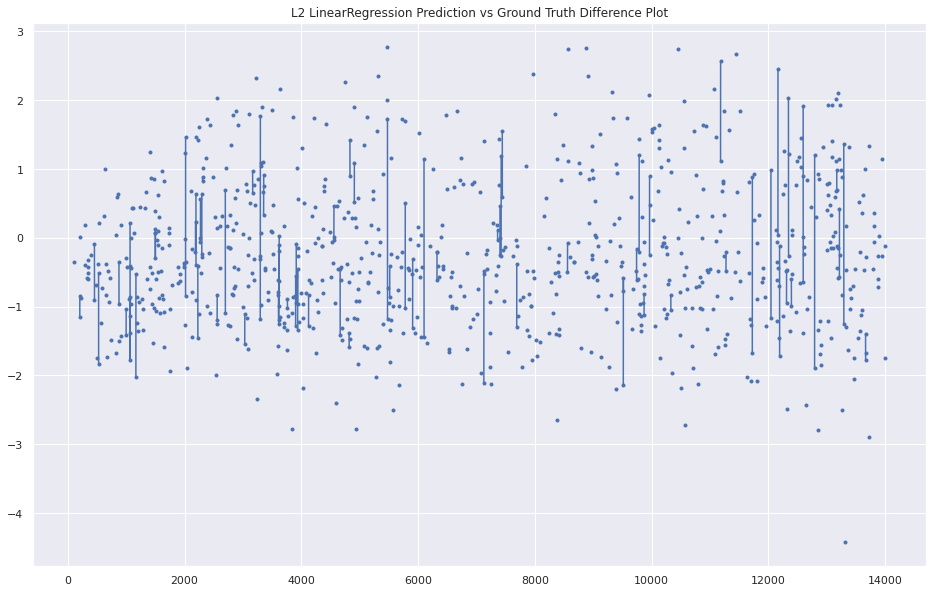

In [167]:
ridge, ridge_y_pred = RidgeRunner(ar_x_train, ar_y_train, ar_x_test, ar_y_test)

######**RandomForestRegressor**

RandomForestRegressor score is: 0.3129
RandomForestRegressor MSE: 0.7544
RandomForestRegressor MAE: 0.6741


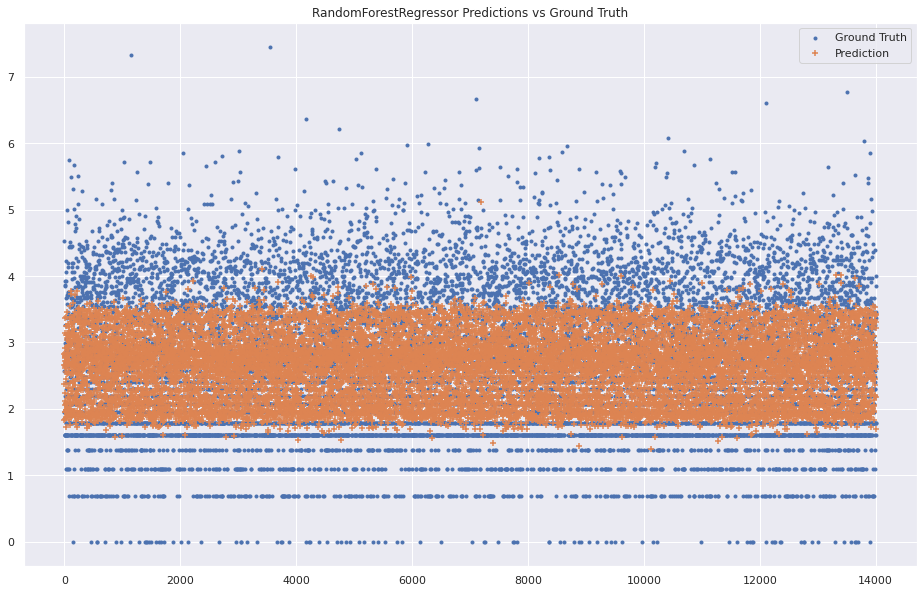

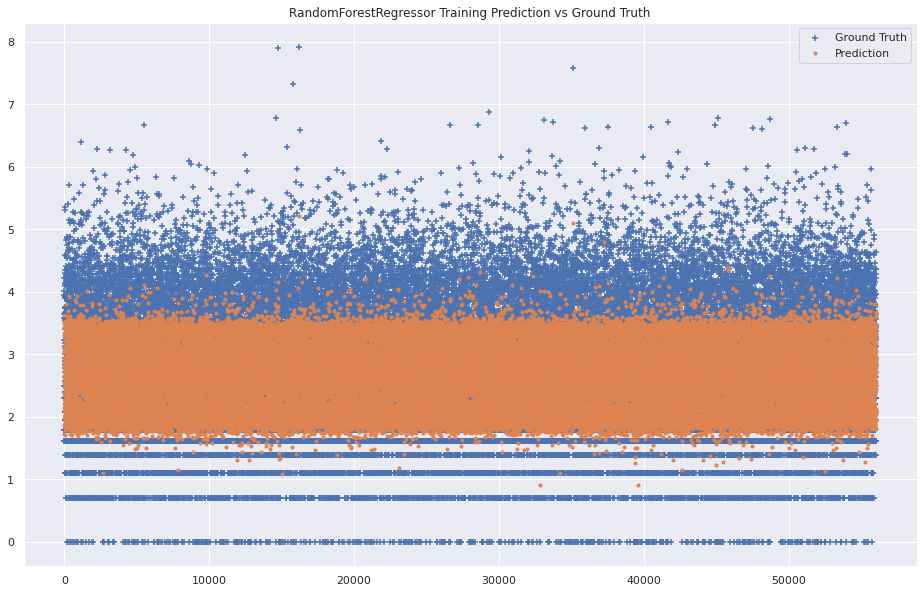

RandomForestRegressor prediction vs truth difference:
 count    872.000000
mean      -0.227905
std        1.057123
min       -2.955027
25%       -1.004024
50%       -0.314658
75%        0.450809
max        2.614592
dtype: float64


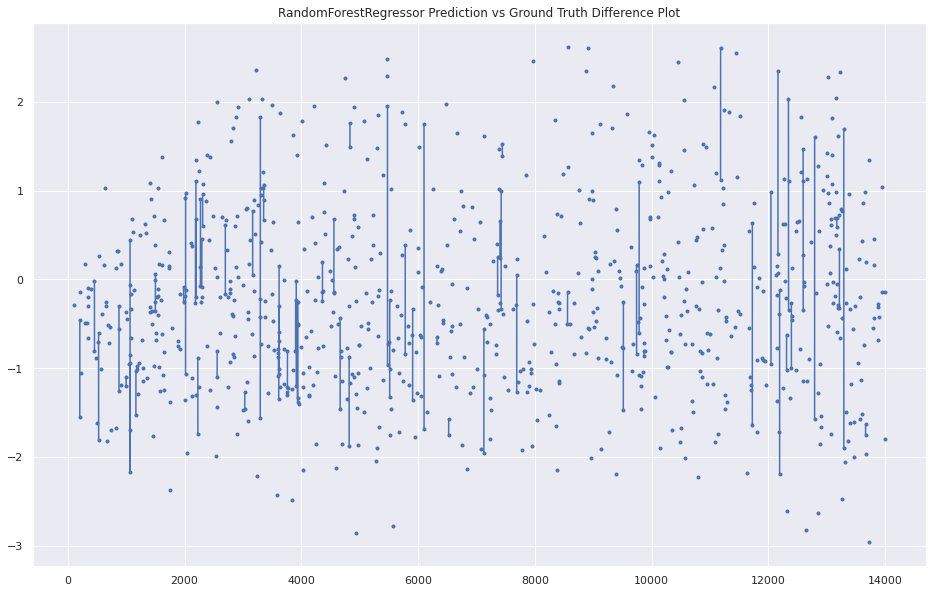

In [168]:
rf_reg, rf_reg__y_pred = RandomForestRegressorRunner(ar_x_train, ar_y_train, ar_x_test, ar_y_test)

#####**Classification**

In [169]:
all_clf_df = GetDataSet(data=adoption_training_df, has_all=True, dog_only=False, cat_only=False, categorical=True, cate_func=map_days_to_period)

In [170]:
al_x_train, al_x_test, al_y_train, al_y_test = train_test_split_helper(all_clf_df, label_col='days_in_shelter')

In [171]:
al_x_train, al_x_test = standard_scale_data(al_x_train, al_x_test)

######**LogisticRegression**



LogisticRegression train accuracy score is: 0.4052
LogisticRegression cross validation score is: 0.3995
LogisticRegression test accuracy score is: 0.4083
LogisticRegression classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.41      0.17      0.24      3550
    med[5, 11)       0.37      0.51      0.43      4025
   short[0, 5)       0.48      0.25      0.33      2781
very long(30+)       0.42      0.64      0.51      3649

      accuracy                           0.41     14005
     macro avg       0.42      0.39      0.38     14005
  weighted avg       0.42      0.41      0.38     14005



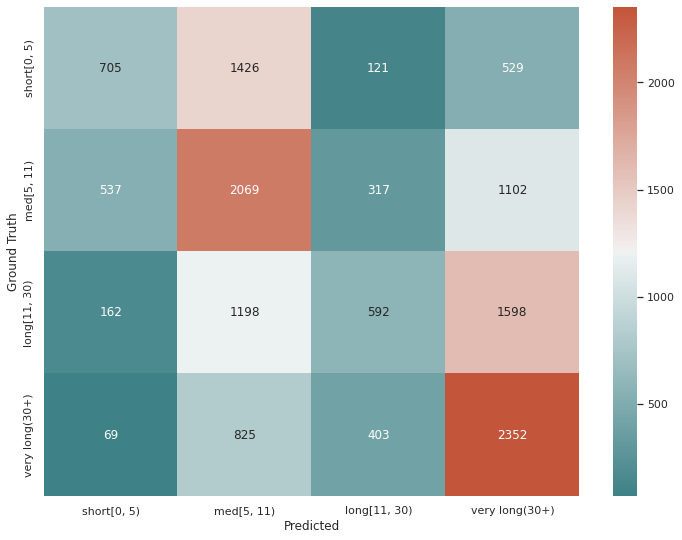

In [172]:
log_reg, log_y_pred = LogisticRegressionRunner(al_x_train, al_y_train, al_x_test, al_y_test)

######**RandomForestClassifier**

RandomForestClassifier train accuracy score is: 0.6398
RandomForestClassifier cross validation score is: 0.4931
RandomForestClassifier accuracy score is: 0.5011
RandomForestClassifier classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.53      0.38      0.44      3550
    med[5, 11)       0.47      0.57      0.52      4025
   short[0, 5)       0.57      0.36      0.44      2781
very long(30+)       0.49      0.65      0.56      3649

      accuracy                           0.50     14005
     macro avg       0.52      0.49      0.49     14005
  weighted avg       0.51      0.50      0.49     14005



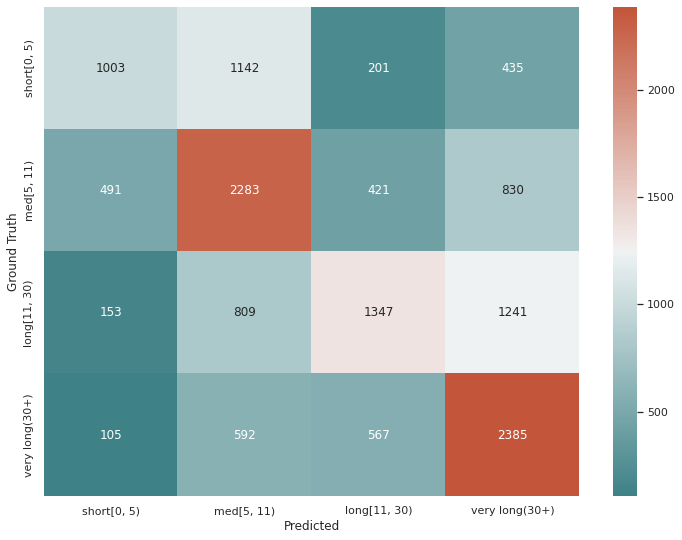

In [173]:
rf_clf, rf_clf_y_pred = RandomForestClassifierRunner(al_x_train, al_y_train, al_x_test, al_y_test)

######**XGBClassifier**

XGBClassifier train accuracy score is: 0.6712
XGBClassifier cross validation score is: 0.6163
XGBClassifier accuracy score is: 0.6276
XGBClassifier classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.63      0.56      0.59      3550
    med[5, 11)       0.67      0.65      0.66      4025
   short[0, 5)       0.68      0.59      0.63      2781
very long(30+)       0.57      0.70      0.63      3649

      accuracy                           0.63     14005
     macro avg       0.63      0.62      0.63     14005
  weighted avg       0.63      0.63      0.63     14005



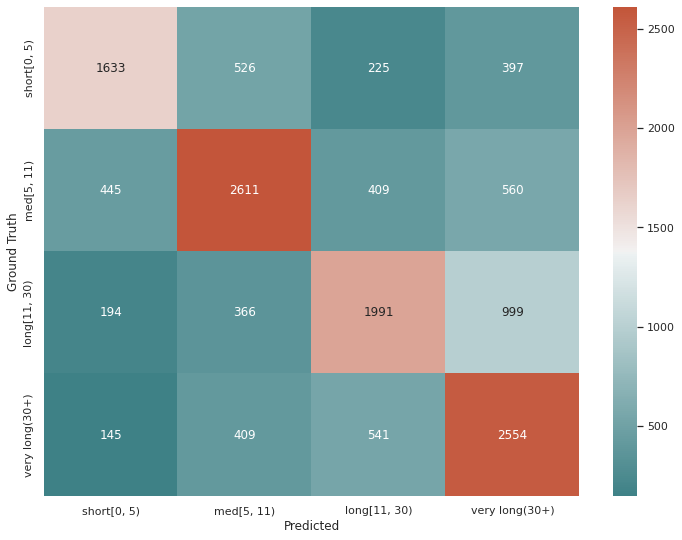

In [174]:
xgb, xgb_y_pred = XGBClassifierRunner(al_x_train, al_y_train, al_x_test, al_y_test)

######**KNN**

KnnClassifier accuracy score is: 0.3921
KnnClassifier classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.36      0.15      0.22      3550
    med[5, 11)       0.36      0.53      0.43      4025
   short[0, 5)       0.45      0.21      0.29      2781
very long(30+)       0.42      0.60      0.49      3649

      accuracy                           0.39     14005
     macro avg       0.40      0.38      0.36     14005
  weighted avg       0.39      0.39      0.37     14005



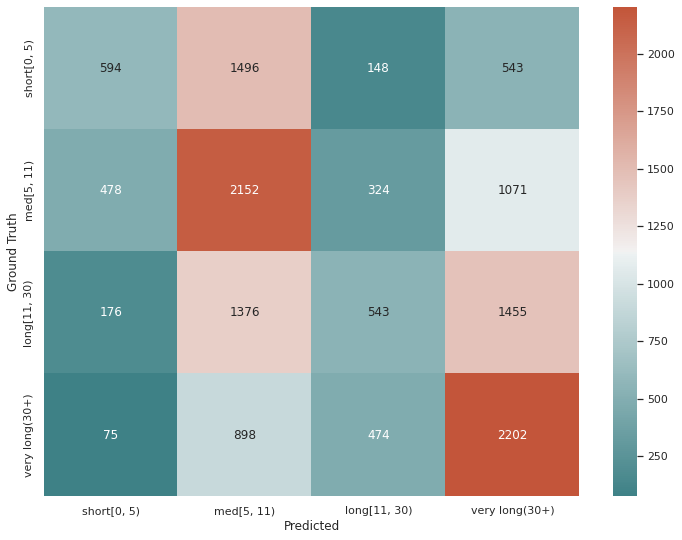

In [175]:
knn, knn_y_pred = KnnClassifierRunner(al_x_train, al_y_train, al_x_test, al_y_test, n_neighbors=200)

######**Multiclass-NeuralNet**

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier accuracy score is: 0.4241
MLPClassifier classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.39      0.28      0.32      3550
    med[5, 11)       0.40      0.42      0.41      4025
   short[0, 5)       0.46      0.37      0.41      2781
very long(30+)       0.44      0.62      0.51      3649

      accuracy                           0.42     14005
     macro avg       0.42      0.42      0.41     14005
  weighted avg       0.42      0.42      0.42     14005



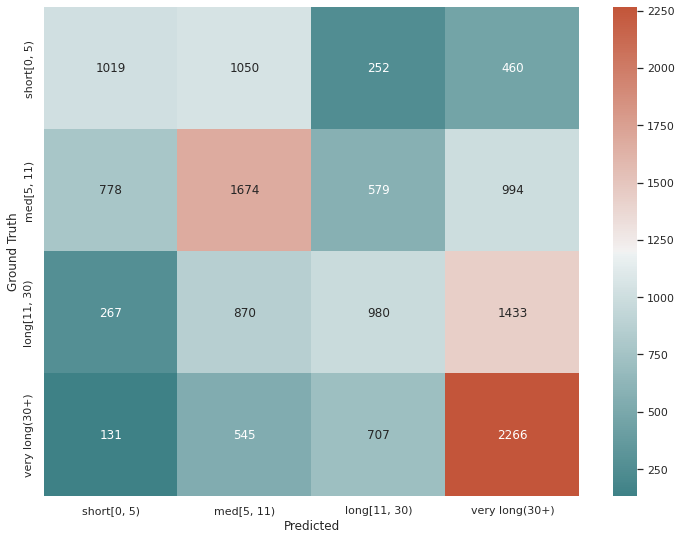

In [176]:
nn, nn_y_pred = MLPClassifierRunner(al_x_train, al_y_train, al_x_test, al_y_test)

####Dog Data Only

In [177]:
dog_df = GetDataSet(data=adoption_training_df, has_all=False, dog_only=True, cat_only=False, categorical=True, cate_func=map_days_to_period)

In [178]:
dog_x_train, dog_x_test, dog_y_train, dog_y_test = train_test_split_helper(dog_df, label_col='days_in_shelter')

In [179]:
dog_x_train, dog_x_test = standard_scale_data(dog_x_train, dog_x_test,)

######**LogisticRegression**



LogisticRegression train accuracy score is: 0.4349
LogisticRegression cross validation score is: 0.4278
LogisticRegression test accuracy score is: 0.4159
LogisticRegression classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.42      0.23      0.30      1854
    med[5, 11)       0.40      0.63      0.49      2737
   short[0, 5)       0.45      0.29      0.35      1992
very long(30+)       0.44      0.42      0.43      1419

      accuracy                           0.42      8002
     macro avg       0.43      0.39      0.39      8002
  weighted avg       0.42      0.42      0.40      8002



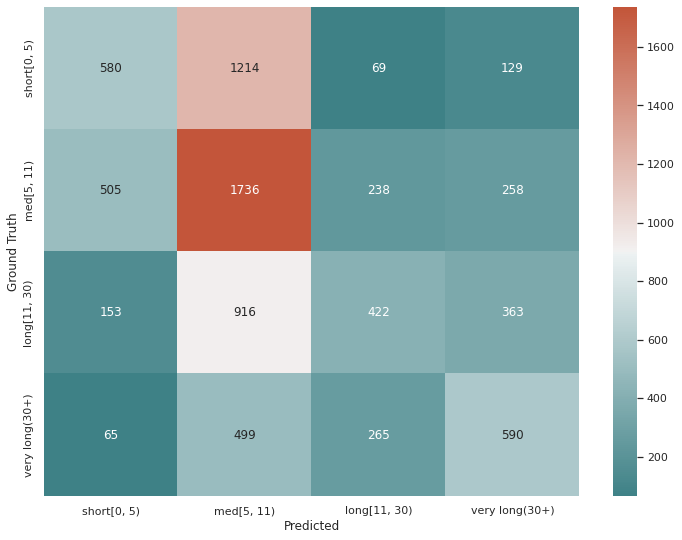

In [180]:
dog_log, dog_log_y_pred = LogisticRegressionRunner(dog_x_train, dog_y_train, dog_x_test, dog_y_test)

######**RandomForestClassifier**

RandomForestClassifier train accuracy score is: 0.6797
RandomForestClassifier cross validation score is: 0.5433
RandomForestClassifier accuracy score is: 0.5350
RandomForestClassifier classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.55      0.48      0.51      1854
    med[5, 11)       0.50      0.66      0.57      2737
   short[0, 5)       0.58      0.48      0.53      1992
very long(30+)       0.59      0.44      0.51      1419

      accuracy                           0.53      8002
     macro avg       0.55      0.52      0.53      8002
  weighted avg       0.54      0.53      0.53      8002



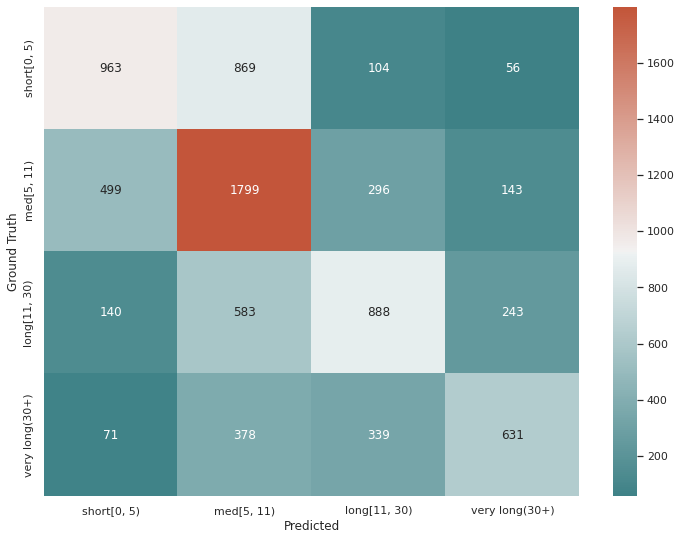

In [181]:
dog_rfc, dog_rfc_y_pred = RandomForestClassifierRunner(dog_x_train, dog_y_train, dog_x_test, dog_y_test)

######**XGBClassifier**

XGBClassifier train accuracy score is: 0.7368
XGBClassifier cross validation score is: 0.6710
XGBClassifier accuracy score is: 0.6702
XGBClassifier classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.63      0.67      0.65      1854
    med[5, 11)       0.71      0.71      0.71      2737
   short[0, 5)       0.69      0.63      0.66      1992
very long(30+)       0.62      0.66      0.64      1419

      accuracy                           0.67      8002
     macro avg       0.66      0.67      0.66      8002
  weighted avg       0.67      0.67      0.67      8002



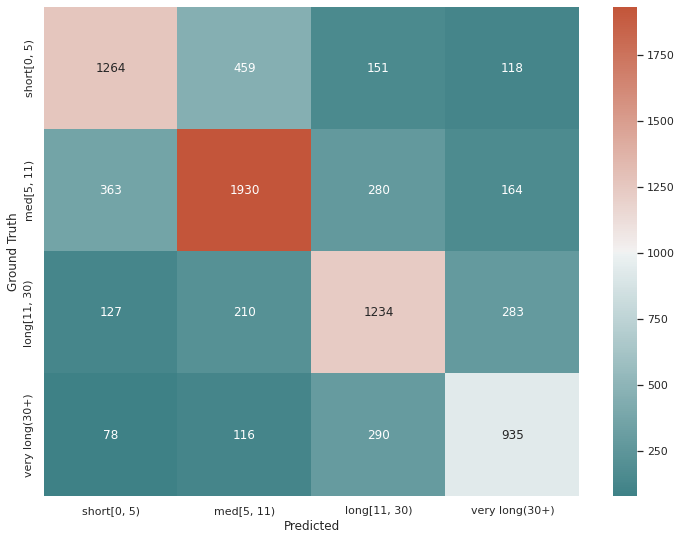

In [184]:
dog_xgb, dog_xgb_y_pred = XGBClassifierRunner(dog_x_train, dog_y_train, dog_x_test, dog_y_test)

####Cat Data Only

In [185]:
cat_df = GetDataSet(data=adoption_training_df, has_all=False, dog_only=False, cat_only=True, categorical=True, cate_func=map_days_to_period)

In [186]:
cat_x_train, cat_x_test, cat_y_train, cat_y_test = train_test_split_helper(cat_df, label_col='days_in_shelter')

In [187]:
cat_x_train, cat_x_test, = standard_scale_data(cat_x_train, cat_x_test,)

######**LogisticRegression**



LogisticRegression train accuracy score is: 0.3857
LogisticRegression cross validation score is: 0.3794
LogisticRegression test accuracy score is: 0.3728
LogisticRegression classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.36      0.13      0.19      1707
    med[5, 11)       0.28      0.14      0.19      1344
   short[0, 5)       0.30      0.04      0.07       760
very long(30+)       0.39      0.82      0.53      2193

      accuracy                           0.37      6004
     macro avg       0.33      0.28      0.24      6004
  weighted avg       0.34      0.37      0.30      6004



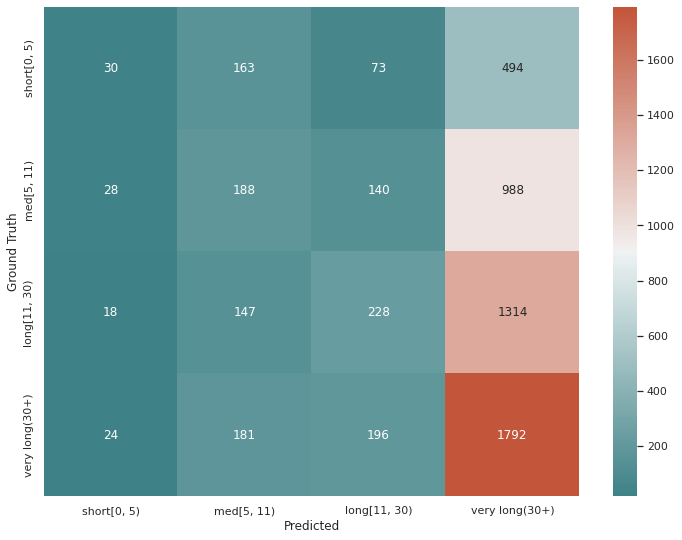

In [188]:
cat_log, cat_log_y_pred = LogisticRegressionRunner(cat_x_train, cat_y_train, cat_x_test, cat_y_test)

######**RandomForestClassifier**

RandomForestClassifier train accuracy score is: 0.6670
RandomForestClassifier cross validation score is: 0.4418
RandomForestClassifier accuracy score is: 0.4564
RandomForestClassifier classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.47      0.28      0.35      1707
    med[5, 11)       0.44      0.34      0.38      1344
   short[0, 5)       0.42      0.20      0.28       760
very long(30+)       0.46      0.75      0.57      2193

      accuracy                           0.46      6004
     macro avg       0.45      0.39      0.40      6004
  weighted avg       0.45      0.46      0.43      6004



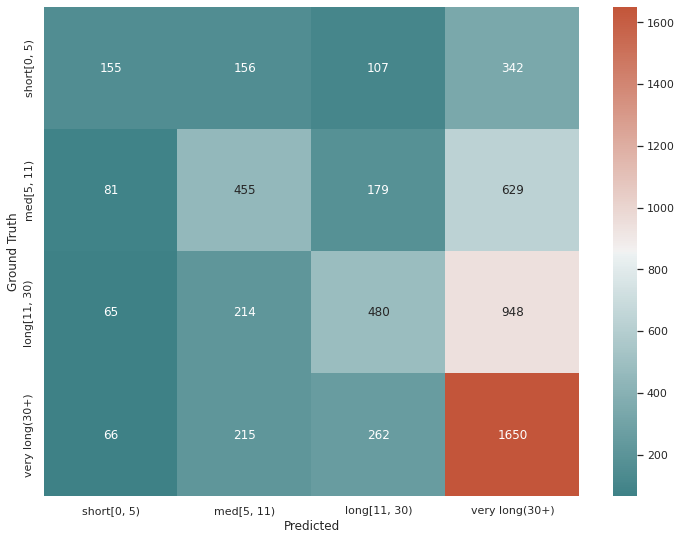

In [189]:
cat_rfc, cat_rfc_y_pred = RandomForestClassifierRunner(cat_x_train, cat_y_train, cat_x_test, cat_y_test)

######**XGBClassifier**

XGBClassifier train accuracy score is: 0.6313
XGBClassifier cross validation score is: 0.5491
XGBClassifier accuracy score is: 0.5538
XGBClassifier classification report:
                 precision    recall  f1-score   support

  long[11, 30)       0.58      0.45      0.51      1707
    med[5, 11)       0.57      0.53      0.55      1344
   short[0, 5)       0.57      0.42      0.49       760
very long(30+)       0.53      0.69      0.60      2193

      accuracy                           0.55      6004
     macro avg       0.56      0.52      0.54      6004
  weighted avg       0.56      0.55      0.55      6004



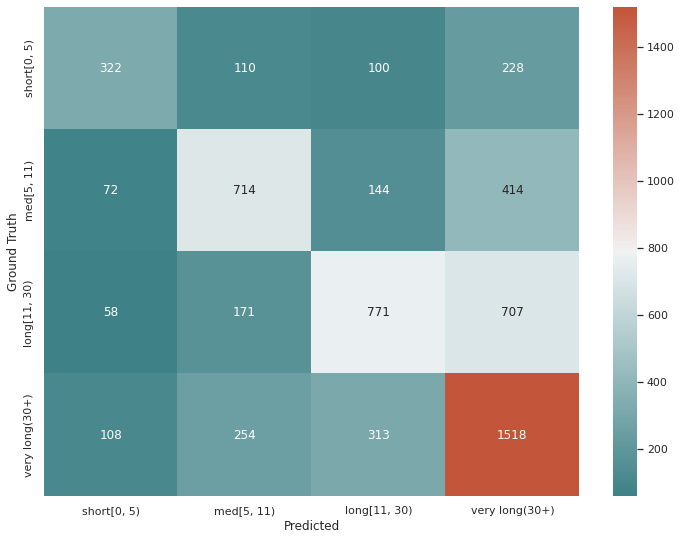

In [190]:
cat_rfc_xgb, cat_rfc_xgb_y_pred = XGBClassifierRunner(cat_x_train, cat_y_train, cat_x_test, cat_y_test)